# Neural Networks Image Mean IoU Score


## Author: Alexander Goudemond, Student Number: 219030365

Please ensure the following folders containg images exist:

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_ST

------------------------------------------------------

Then, please ensure a seperate folder with the notebooks and text files exists:

drive > MyDrive > COMP700_Neural_Network_Code

------------------------------------------------------

The first 4 image folders were generated offline by the other notebooks and then uploaded to Google Drive, whereas the next 6 were generated by the notebook 011. The final 2 were generated by 015

In the notebooks where the Neural Networks were trained, we generated a Mean IoU score based on the patchified masks. In this notebook, we wish to patchify and rebuild images, and then calculate the Mean IoU Scores of those complete predicted masks.

The interest is in identifying if there is a difference between the scores - and if so, what the best performing models are! 

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from os import getcwd
google_drive_path = "/drive/MyDrive"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

## Installs

In [3]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [4]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

from patchify import patchify, unpatchify

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import clear_output


# Functions

In [5]:
# returns tuple
def extractDirectoryPaths(path):
    x_directory_locations, y_directory_locations = [], []
    temp = ""

    with open(path) as f:
        lines = f.readlines()
        for item in lines:
            temp = item[ : -1] # remove newline char at end
            if ("X" in temp):
                x_directory_locations.append( temp ) 
            else:
                y_directory_locations.append( temp ) 

    return (x_directory_locations, y_directory_locations)
###

def loadImagePathsFromArray(array):
    image_paths = []

    for path in array:
        for root, dirs, files in walk(path):
            if (len(files) != 0):
                for item in files:
                    image_paths.append(root + "/" + item)

    image_paths.sort()

    return image_paths
###

In [6]:
def patchifyImages(array, patch_size, imageIsMask, isColourImage=True):
    scaler = MinMaxScaler()
    image_dataset, label_dataset = [], []
    count, appendix = 0, 0
    length = len(array)

    for img_path in array:
        count += 1

        if (imageIsMask):
            image = plt.imread(img_path)
            plt.imsave("temp.png", image, cmap='gray')
            image = cv2.imread("temp.png")
        else:
            image = cv2.imread(img_path)

        #Nearest size divisible by our patch size
        SIZE_X = (image.shape[1] // patch_size) * patch_size 
        SIZE_Y = (image.shape[0] // patch_size) * patch_size 

        image = fromarray(image)
        # Crop entire image into desirable shape
        image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
        image = np.array(image)

        if (count % 50 == 0 or count == 1):
          print("Patchifying ", count, "/", length, " images", sep="")

        #Extract patches from each image
        if (isColourImage):
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        else:
            patches_img = patchify(image, (patch_size, patch_size), step=patch_size) # grayscale patchify
        
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:]
                
                #Use minmaxscaler instead of just dividing by 255. 
                single_patch_img = scaler.fit_transform(
                    single_patch_img.reshape(-1, single_patch_img.shape[-1])
                ).reshape( single_patch_img.shape )
                
                #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                #Drop the extra unecessary dimension that patchify adds. 
                single_patch_img = single_patch_img[0] 

                # scale up values - don't do this for the NN!
                # img_new = (single_patch_img * 255).astype(int) 
                img_new = single_patch_img

                image_dataset.append(img_new)

                # extract folder path, remove extension, and add a counter
                label_dataset.append( extractRhsString(img_path, "T/")[ : -4] + "_" + str(appendix) )
                appendix += 1

        appendix = 0 # reset

    print("Patchify process complete!")

    if (exists("temp.png")):
        remove("temp.png")

    return image_dataset, label_dataset
###

In [7]:
def extractRhsString(string, symbol):
    index = string.rfind(symbol)
    return string[ index + len(symbol) : ]
###

In [8]:
from tensorflow import keras
from keras.utils import array_to_img

def display(display_list, title=[], figsize=(15, 15)):
    plt.figure(figsize=figsize)

    # update if title not provided
    if (len(title) == 0):
      title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i], wrap=True)
        
        # handle 2D and 3D images
        if (len(display_list[i].shape) == 3 ):
            plt.imshow( array_to_img(display_list[i]), cmap="gray")
        else:
            plt.imshow( display_list[i], cmap="gray")
            
        plt.axis('off')
    plt.tight_layout() # prevents overlap
    plt.show()
###


In [9]:
from keras.models import load_model

def getModel(path, model_name):
    return load_model(path + model_name)
###

In [10]:
def reshapePatchifiedImages(og_image, patches, height, width, patch_size, invert_scaling=True):
    # use original patchify to get integer slices of image
    collection = patchify(og_image, (patch_size, patch_size, 3), step=patch_size)
    counter = 0
    row_of_images, organised_patches = [], []

    # i * j == (patchifyIndividualImage(...).shape)[0]
    for i in range(height // patch_size):
        for j in range(width // patch_size):
            single_image = patches[counter]                   # 3D object

            # map to integer again?
            if (invert_scaling):
                # use og_image patches to find min and max ints
                min = np.min(collection[i,j,:,:][0])
                max = np.max(collection[i,j,:,:][0])
                single_image = (single_image * (max - min)) + min

            new_img = [single_image]                          # 4D object    
            
            row_of_images.append( new_img )

            counter += 1
        
        # print(len(row_of_images))
        organised_patches.append( row_of_images )             # stick rows ontop of one another
        row_of_images = [] 
    
    return organised_patches
###

In [11]:
def rebuildImageFromPatches(og_image, image_patches, patch_size, invert_scaling=True):
    height, width, _ = np.array(og_image).shape
    # height, width = np.array(og_image).shape
    

    redesigned_images = reshapePatchifiedImages(og_image, 
                                                image_patches, 
                                                height, 
                                                width, 
                                                patch_size, 
                                                invert_scaling=invert_scaling)
    # print(np.array(og_image).shape)
    # print(np.array(redesigned_images).shape)
    
    redesigned_images = np.array(redesigned_images)
    rebuilt_image = unpatchify(redesigned_images, np.array(og_image).shape)
    
    return rebuilt_image
###

In [12]:
def cropImage(image, patch_size):
    #Nearest size divisible by our patch size
    SIZE_X = (image.shape[1] // patch_size) * patch_size 
    SIZE_Y = (image.shape[0] // patch_size) * patch_size 

    image = fromarray(image)
    # Crop entire image into desirable shape
    image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
    image = np.array(image)
    
    return image
###

In [13]:
# gt_x_organised_predictions = []
def predictPatchesAndRebuild(og_images, patches, patch_size, model, threshold, invert_scaling=True, apply_threshold=False):
    rebuilt_predictions = []
    length = len(patches)
    counter = 0
    for collection in patches:
        # print(counter)
        # first collection may have length of 9
        patchified_images = np.array(collection)
        patchified_predictions = model.predict(patchified_images, verbose = 0) # verbose=0 means "Dont print output"

        predictions = patchified_predictions

        # adjust threshold here
        if (apply_threshold):
            patchified_predictions_thresh = patchified_predictions 
            patchified_predictions_thresh[patchified_predictions_thresh >= threshold] = 1
            patchified_predictions_thresh[patchified_predictions_thresh < threshold] = 0
            
            predictions = patchified_predictions_thresh # update if necessary
        

        # gt_x_organised_predictions.append( patchified_predictions_thresh )
        img = plt.imread(og_images[counter])
        plt.imsave("temp.png", img, cmap='gray')
        img = cv2.imread("temp.png")
        img = cropImage(img, patch_size)

        rebuilt = rebuildImageFromPatches(img, predictions, patch_size, invert_scaling=invert_scaling)

        rebuilt_predictions.append(rebuilt)

        counter += 1

        if (counter % 50 == 0) and (counter > 0):
            print("predicted", counter, "collections out of", length)

    if (exists("temp.png")):
        remove("temp.png")
    
    return rebuilt_predictions
###


In [14]:
# create directories for work we create
def tryMakeDirectories(current_directory, myList):
    path = ""
    for item in myList:
        # initialize
        if (path == ""):
            path = item
        else:
            path = path + "/" + item
            
        try:
            # join comes from os.path
            mkdir( join(current_directory, path) )
        except FileExistsError:
            # print("Folder already exists!")
            pass
        except:
            print("Unknown Error Encountered...")
###

In [15]:
from shutil import move

# save to current location, then move to desired location
def saveImages(array, folder, filename):
    count = 0
    temp = ""
    zeroes = "0"
    for image in array:
        count += 1
        temp = str(count)
        zeroes = "0" * (4 - len(temp))
        path = getcwd() + "/" + filename + "_" + zeroes + temp + ".png"
        image = np.clip(image, 0.0, 1.0) # just incase Matplotlib complains
        
        # print(path)

        plt.imsave(path, image)
        x = cv2.imread(path)
        cv2.imwrite(path, x)
    
    print("Images saved successfuly")
    moveImages(filename, folder, count)
###

def moveImages(filename, folder, numFiles):
    count = 0
    temp = ""
    zeroes = "0"
    taskComplete = False
    for root, dirs, files in walk(getcwd()):
        if (not taskComplete):
            for someFile in files:
                if (filename in someFile):
                    # print("Found ya")
                    count += 1
                    move(someFile, folder + "/" + someFile)

                    if (count >= numFiles):
                      taskComplete = True
                      break
    print("Images moved successfully")
###

In [16]:
#IOU
def calculateMeanIouScore(model, x_test, y_test, pred_y):
    # pred_y = model.predict(x_test)
    # pred_y_thresholded = pred_y > 0.5

    intersection = np.logical_and(y_test, pred_y)
    union = np.logical_or(y_test, pred_y)

    iou_score = np.sum(intersection) / np.sum(union)

    # print("IoU score is: ", iou_score)

    return iou_score
###

# Read in Image Paths

Next, we can read the images into our variables, then save them into a text file

In [17]:
text_file_location = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"

In [18]:
filename = "raw_training_paths_gt.txt"
gt_raw_x_image_paths, gt_raw_y_image_paths = extractDirectoryPaths(text_file_location + filename)

gt_raw_x_images = loadImagePathsFromArray(gt_raw_x_image_paths)
gt_raw_y_images = loadImagePathsFromArray(gt_raw_y_image_paths)

if (len(gt_raw_x_images) == len(gt_raw_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [19]:
len(gt_raw_x_images)

578

In [20]:
filename = "raw_training_paths_st.txt"
st_raw_x_image_paths, st_raw_y_image_paths = extractDirectoryPaths(text_file_location + filename)

st_raw_x_images = loadImagePathsFromArray(st_raw_x_image_paths)
st_raw_y_images = loadImagePathsFromArray(st_raw_y_image_paths)

if (len(st_raw_x_images) == len(st_raw_y_images)):
    print("Same quastity of images and masks!")
else:
    print("Not all pictures match...")

Same quastity of images and masks!


In [21]:
len(st_raw_x_images)

7742

In [22]:
filename = "processed_training_paths_gt.txt"
gt_processed_x_image_paths, gt_processed_y_image_paths = extractDirectoryPaths(text_file_location + filename)

gt_processed_x_images = loadImagePathsFromArray(gt_processed_x_image_paths)
gt_processed_y_images = loadImagePathsFromArray(gt_processed_y_image_paths)

if (len(gt_processed_x_images) == len(gt_processed_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [23]:
len(gt_processed_x_images)

578

In [24]:
filename = "processed_training_paths_st.txt"
st_processed_x_image_paths, st_processed_y_image_paths = extractDirectoryPaths(text_file_location + filename)

st_processed_x_images = loadImagePathsFromArray(st_processed_x_image_paths)
st_processed_y_images = loadImagePathsFromArray(st_processed_y_image_paths)

if (len(st_processed_x_images) == len(st_processed_y_images)):
    print("Same quastity of images and masks!")
else:
    print("Not all pictures match...")

Same quastity of images and masks!


In [25]:
len(st_processed_x_images)

7742

## Verify data corresponds:

In [26]:
count = 0
for i in range(len(gt_raw_x_images)):
    if ( extractRhsString(gt_raw_x_images[i], "/t") != extractRhsString(gt_raw_y_images[i], "/man_seg") ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


In [27]:
count = 0
for i in range(len(gt_processed_x_images)):
    if ( extractRhsString(gt_processed_x_images[i], "_t")[:-4] != extractRhsString(gt_processed_y_images[i], "/man_seg")[:-4] ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


In [28]:
count = 0
for i in range(len(st_raw_x_images)):
    if ( extractRhsString(st_raw_x_images[i], "/t") != extractRhsString(st_raw_y_images[i], "/man_seg") ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


In [29]:
count = 0
for i in range(len(gt_processed_x_images)):
    if ( extractRhsString(gt_processed_x_images[i], "_t")[:-4] != extractRhsString(gt_processed_y_images[i], "/man_seg")[:-4] ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


# Patchify and evaluate all test datasets

# GT Raw 128 Content

## GT 128 Prep

We next need to conduct a bulk Patchify process for each of the 4 models we desire to verify

In [ ]:
scaler = MinMaxScaler()
patch_size = 128

### Shuffle the data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    gt_raw_x_images, gt_raw_y_images, test_size=0.33, random_state=42
)

x_train = x_train[0:240]
y_train = y_train[0:240]

### Load Test X and Test Y Images

In [ ]:
# read in with opencv to produce 3 tuple images
test_x = []

for path in x_test:
    test_x.append(cropImage(cv2.imread(path), patch_size))

test_y = []

for path in y_test:
    img = plt.imread(path)
    plt.imsave("temp.png", img, cmap="gray")
    test_y.append(cropImage(cv2.imread("temp.png"), patch_size))

if (exists("temp.png")):
    remove("temp.png")

In [ ]:
binary_test_y = []

# update masks from multiclass to binary class
for i in range(len(test_y)):
    img = test_y[i].copy() # clone array to preserve info
    img[img > 0] = 1
    binary_test_y.append(img)

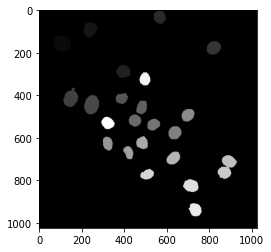

In [ ]:
plt.imshow(test_y[0])
plt.show()

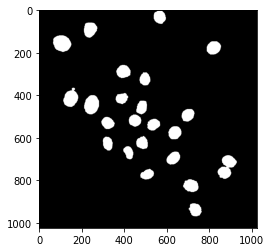

In [ ]:
plt.imshow(binary_test_y[0]*255) # update because 0 and 1
plt.show()

### Patchify all images

To avoid crashes, we need to limit the intake patches. Thankfully, we only need to use the test images, as the original training model did not see that!

In [ ]:
patch_size = 128
gt_x_patchify_images, gt_x_patchify_labels = patchifyImages(x_test, patch_size, imageIsMask=False)

print()
print(len(gt_x_patchify_images), "images exist")

Patchifying 1/191 images
Patchifying 50/191 images
Patchifying 100/191 images
Patchifying 150/191 images
Patchify process complete!

8352 images exist


### Sort the patches into collections

Now, each image was cut into pieces, due to the patch size. We can take advantage of a property of the patchify process whereby 

(image_width // patch_size) * (image_height // patch_size) == number of patches

In [ ]:
patch_size = 128
gt_x_organised_patches = []
starting_index, end_index = 0, 0

for path in x_test:
    image = plt.imread(path)
    X_PATCHES = (image.shape[1] // patch_size)
    Y_PATCHES = (image.shape[0] // patch_size)

    end_index = starting_index + (X_PATCHES * Y_PATCHES)

    gt_x_organised_patches.append( gt_x_patchify_images[starting_index : end_index] )

    starting_index = end_index # update


In [ ]:
len(gt_x_organised_patches[0])

64

## GT Raw 128 1

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_128/"

model = getModel(path, "gt_128_model_1")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     0.65877044
Min Pixel:     5.73274e-10


92


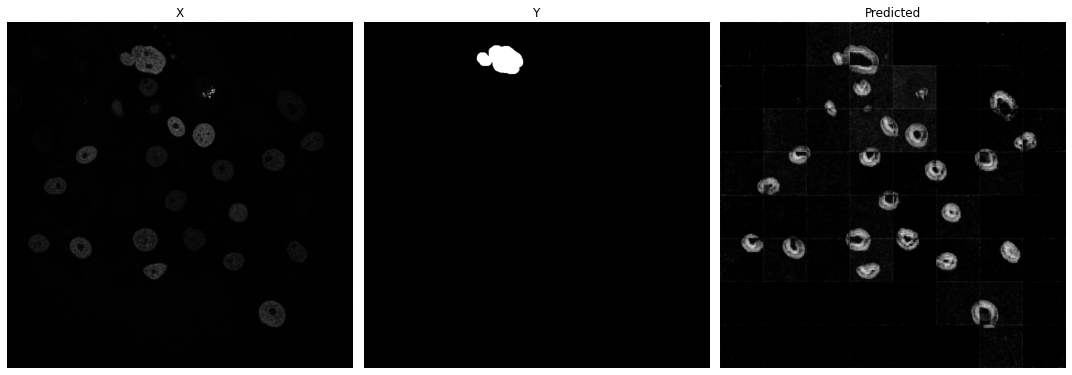

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
i = 92 # pleasant example
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


92


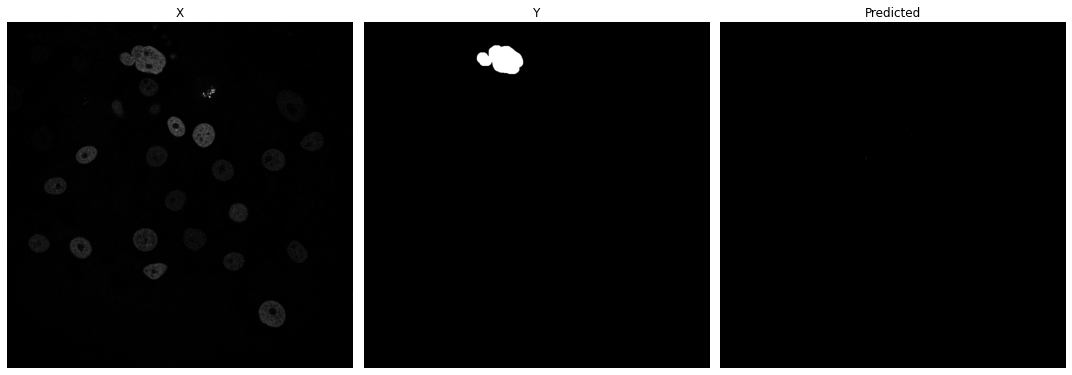

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

2.7845070030351125e-05


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.00029866774515193556


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


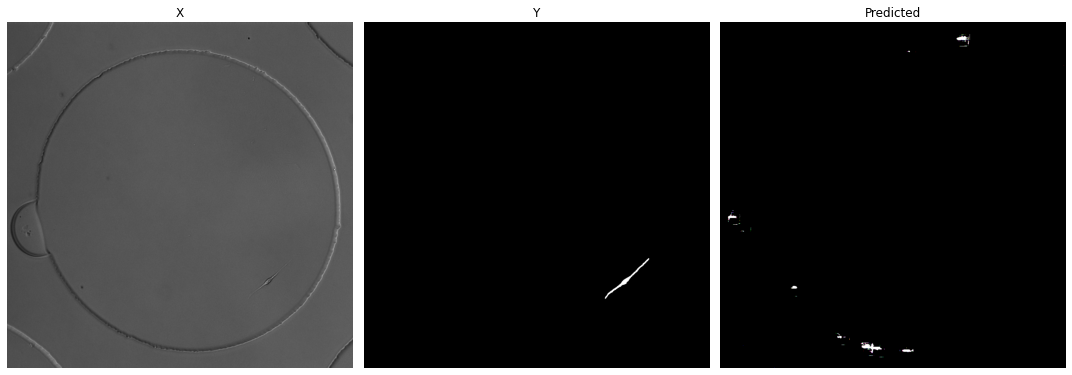

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.2195825829985686


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.03666557844459784


## GT Raw 128 2

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_128/"

model = getModel(path, "gt_128_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     0.0


190


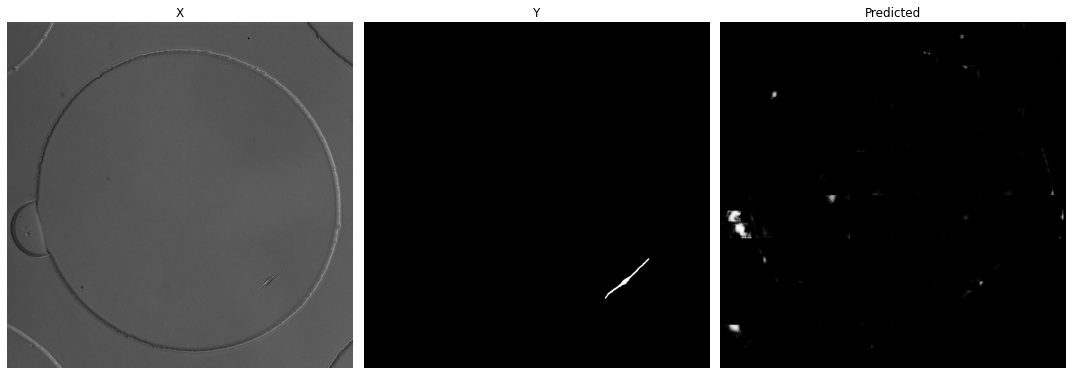

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


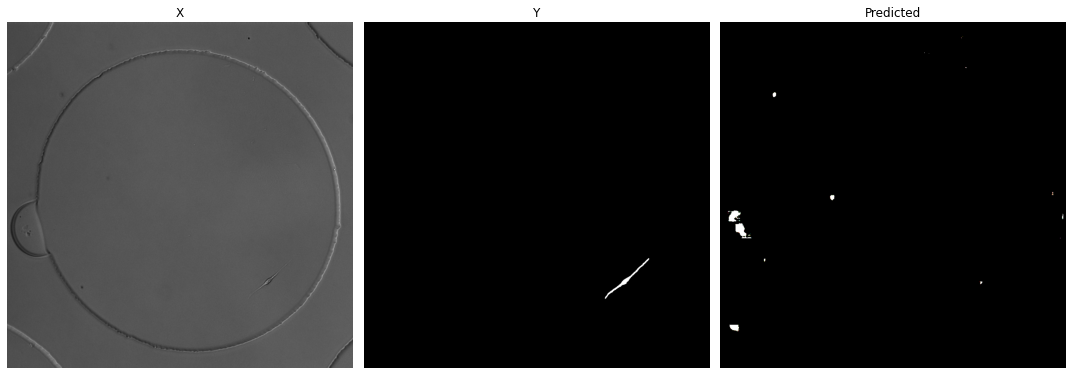

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.12144017074189208


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.13872834508470147


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


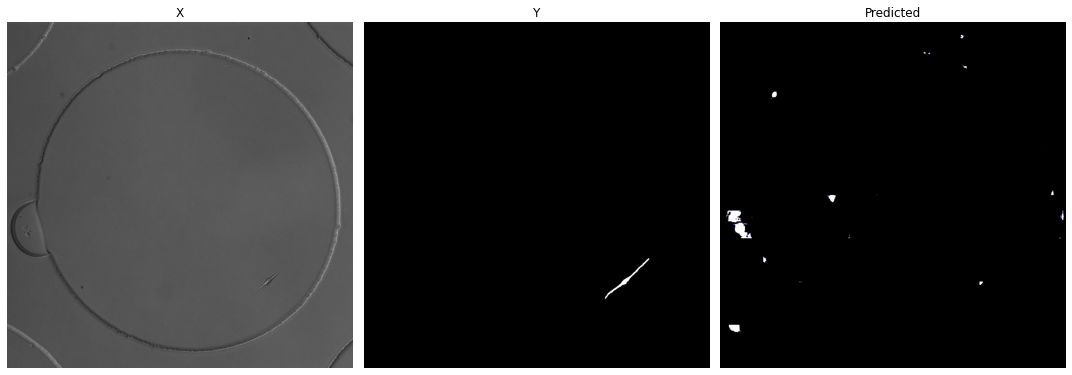

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.19241438395813554


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.14510651207410047


## GT Raw 128 3

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_128/"

model = getModel(path, "gt_128_model_3")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     0.0


190


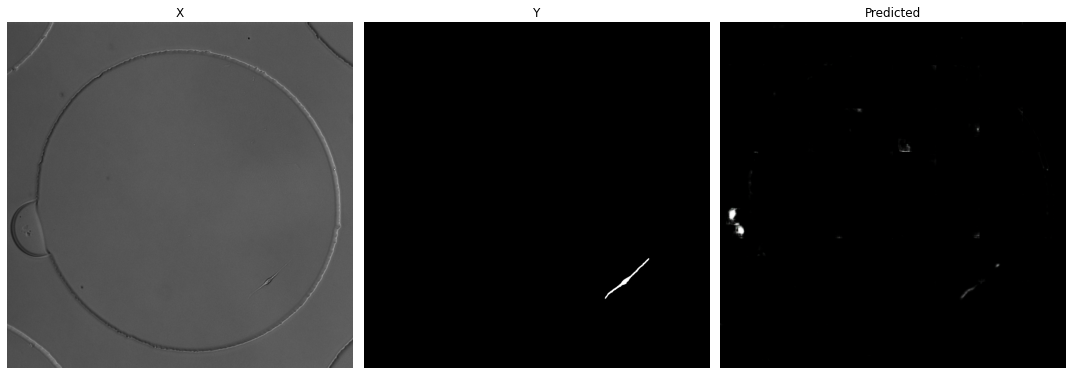

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


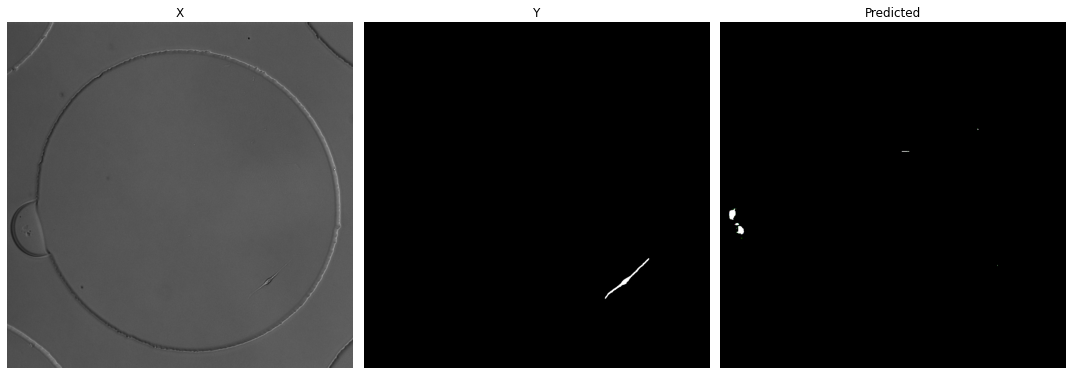

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.32085948038913265


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.16278186893002478


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


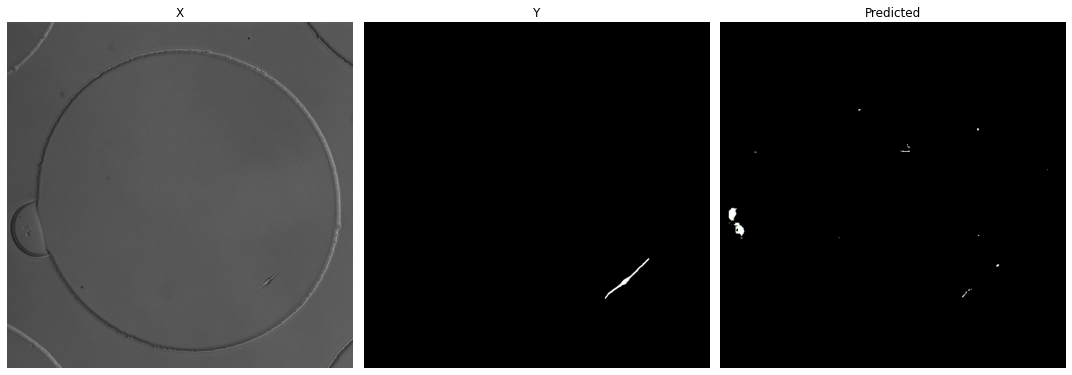

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.43533350572287927


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.18041850913109203


# GT Raw 256 Content

## GT 256 Prep

We next need to conduct a bulk Patchify process for each of the 4 models we desire to verify

In [ ]:
scaler = MinMaxScaler()
patch_size = 256

### Shuffle the data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    gt_raw_x_images, gt_raw_y_images, test_size=0.33, random_state=42
)

x_train = x_train[0:240]
y_train = y_train[0:240]

### Load Test X and Test Y Images

In [ ]:
# read in with opencv to produce 3 tuple images
test_x = []

for path in x_test:
    test_x.append(cropImage(cv2.imread(path), patch_size))

test_y = []

for path in y_test:
    img = plt.imread(path)
    plt.imsave("temp.png", img, cmap="gray")
    test_y.append(cropImage(cv2.imread("temp.png"), patch_size))

if (exists("temp.png")):
    remove("temp.png")

In [ ]:
binary_test_y = []

# update masks from multiclass to binary class
for i in range(len(test_y)):
    img = test_y[i].copy() # clone array to preserve info
    img[img > 0] = 1
    binary_test_y.append(img)

In [ ]:
plt.imshow(test_y[0])
plt.show()

In [ ]:
plt.imshow(binary_test_y[0]*255) # update because 0 and 1
plt.show()

### Patchify all images

To avoid crashes, we need to limit the intake patches. Thankfully, we only need to use the test images, as the original training model did not see that!

In [ ]:
patch_size = 256
gt_x_patchify_images, gt_x_patchify_labels = patchifyImages(x_test, patch_size, imageIsMask=False)

print()
print(len(gt_x_patchify_images), "images exist")

### Sort the patches into collections

Now, each image was cut into pieces, due to the patch size. We can take advantage of a property of the patchify process whereby 

(image_width // patch_size) * (image_height // patch_size) == number of patches

In [ ]:
patch_size = 256
gt_x_organised_patches = []
starting_index, end_index = 0, 0

for path in x_test:
    image = plt.imread(path)
    X_PATCHES = (image.shape[1] // patch_size)
    Y_PATCHES = (image.shape[0] // patch_size)

    end_index = starting_index + (X_PATCHES * Y_PATCHES)

    gt_x_organised_patches.append( gt_x_patchify_images[starting_index : end_index] )

    starting_index = end_index # update


In [ ]:
len(gt_x_organised_patches[0])

## GT Raw 256 1

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_256/"

model = getModel(path, "gt_256_model_1")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     0.7751267
Min Pixel:     1.7310195e-10


92


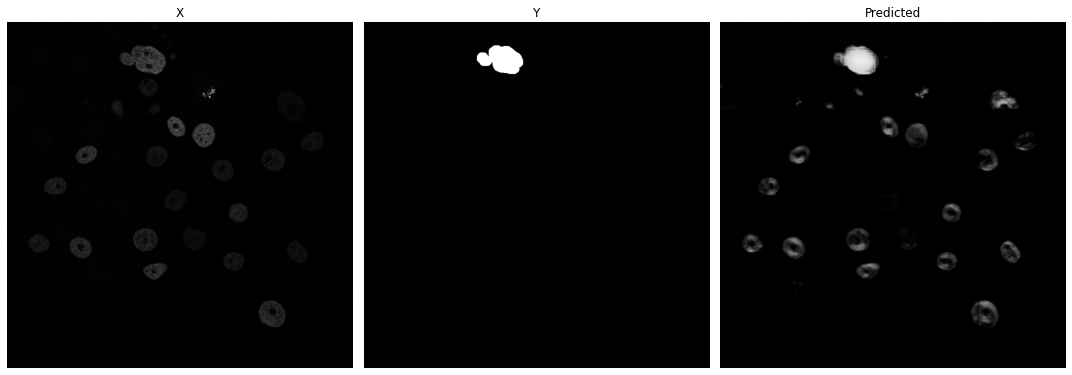

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
i = 92 # pleasant example
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


92


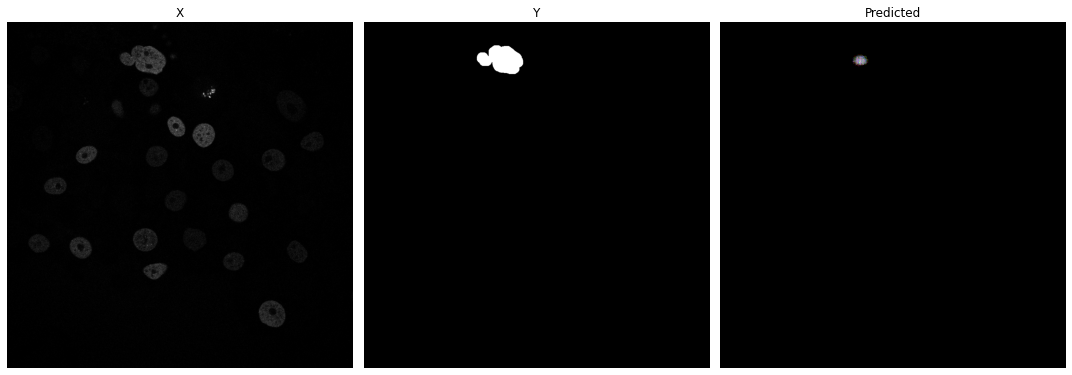

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.0


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.02693414668771239


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


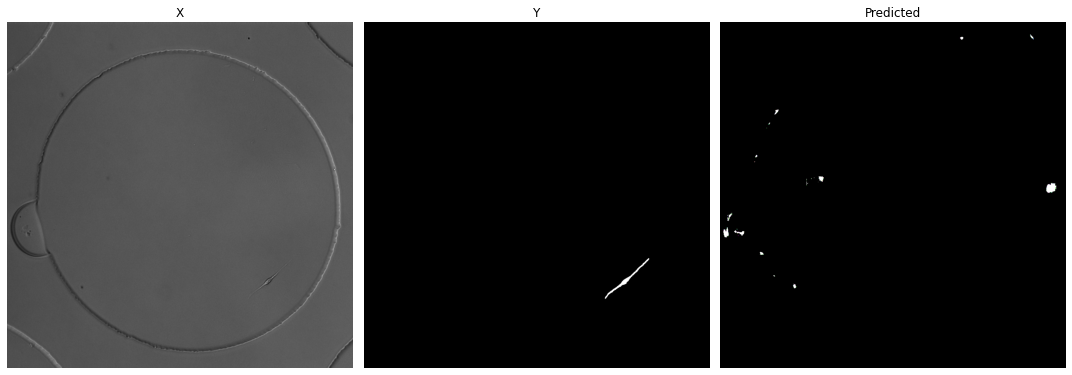

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.11172318416179768


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.19425641730575913


## GT Raw 256 2

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_256/"

model = getModel(path, "gt_256_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     0.0


190


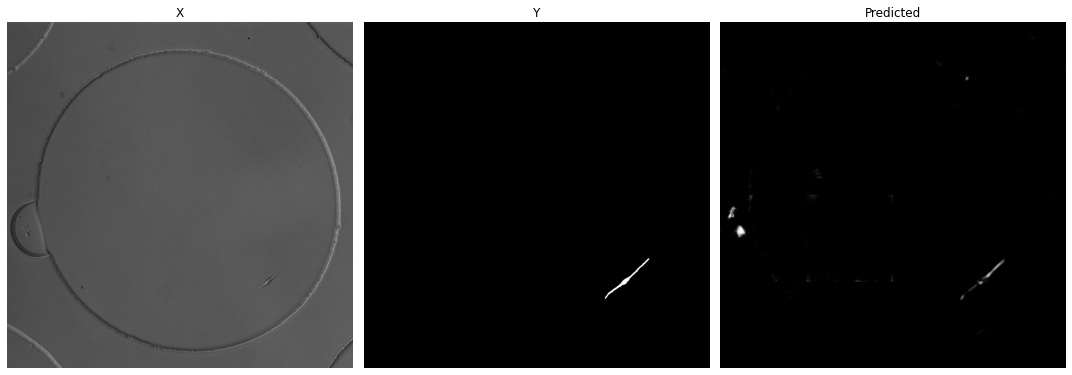

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


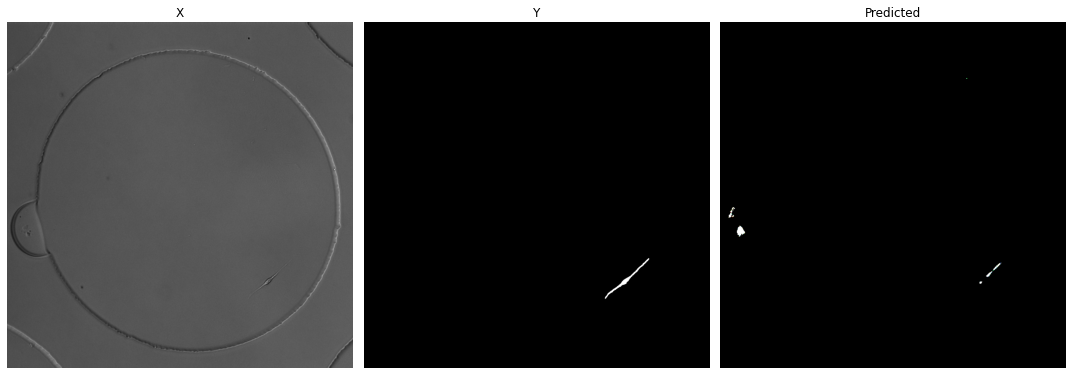

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.03726269971275702


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.2843031591372988


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


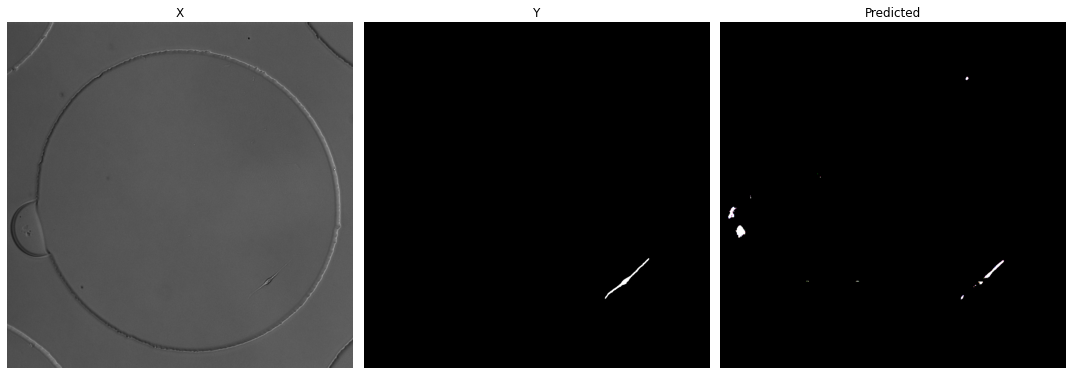

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.0988704097369847


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.29084609719163806


## GT Raw 256 3

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_256/"

model = getModel(path, "gt_256_model_3")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     0.0


190


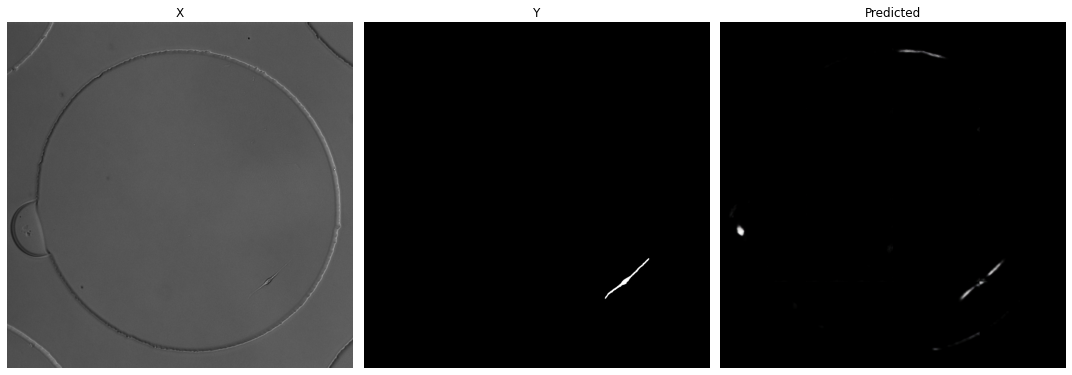

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


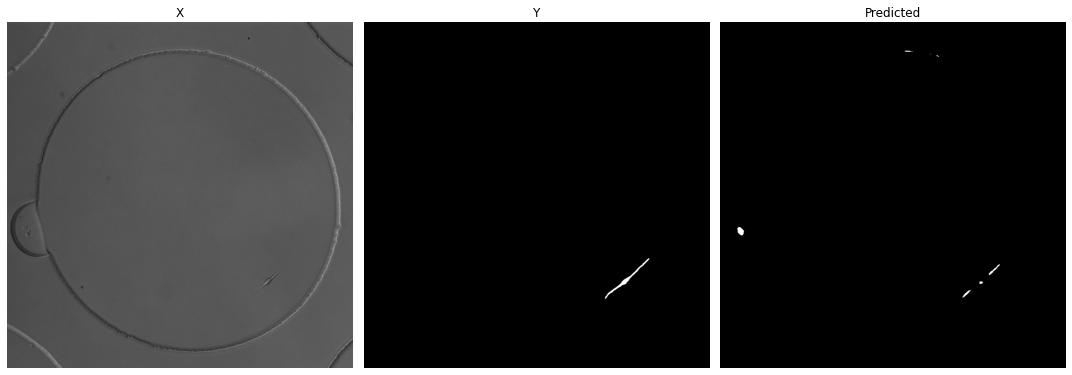

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.11772172857221701


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.2803461238794579


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


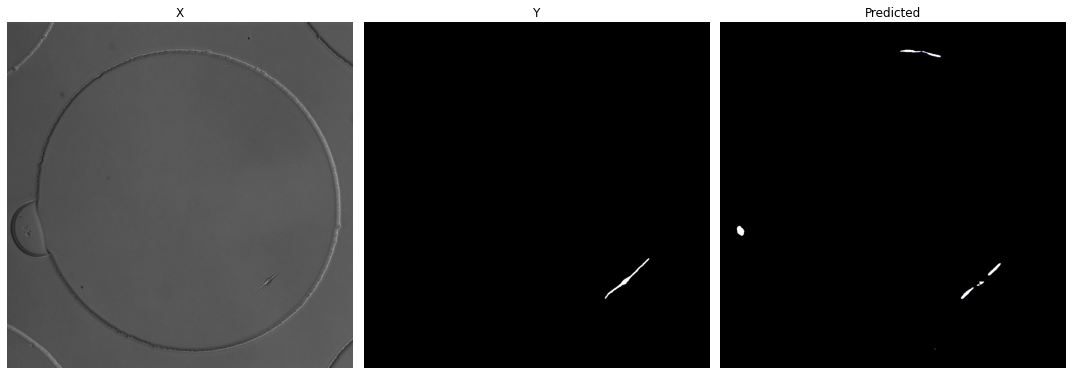

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.15128271758707515


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.2993886106320837


# GT Raw 512 Content

## GT 512 Prep

We next need to conduct a bulk Patchify process for each of the 4 models we desire to verify

In [30]:
scaler = MinMaxScaler()
patch_size = 512

### Shuffle the data

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    gt_raw_x_images, gt_raw_y_images, test_size=0.33, random_state=42
)

x_train = x_train[0:240]
y_train = y_train[0:240]

### Load Test X and Test Y Images

In [32]:
# read in with opencv to produce 3 tuple images
test_x = []

for path in x_test:
    test_x.append(cropImage(cv2.imread(path), patch_size))

test_y = []

for path in y_test:
    img = plt.imread(path)
    plt.imsave("temp.png", img, cmap="gray")
    test_y.append(cropImage(cv2.imread("temp.png"), patch_size))

if (exists("temp.png")):
    remove("temp.png")

In [33]:
binary_test_y = []

# update masks from multiclass to binary class
for i in range(len(test_y)):
    img = test_y[i].copy() # clone array to preserve info
    img[img > 0] = 1
    binary_test_y.append(img)

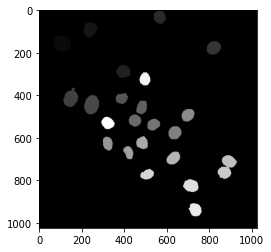

In [34]:
plt.imshow(test_y[0])
plt.show()

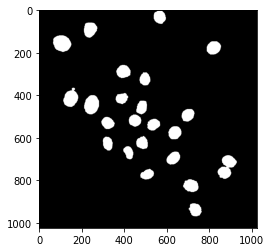

In [35]:
plt.imshow(binary_test_y[0]*255) # update because 0 and 1
plt.show()

### Patchify all images

To avoid crashes, we need to limit the intake patches. Thankfully, we only need to use the test images, as the original training model did not see that!

In [36]:
patch_size = 512
gt_x_patchify_images, gt_x_patchify_labels = patchifyImages(x_test, patch_size, imageIsMask=False)

print()
print(len(gt_x_patchify_images), "images exist")

Patchifying 1/191 images
Patchifying 50/191 images
Patchifying 100/191 images
Patchifying 150/191 images
Patchify process complete!

408 images exist


### Sort the patches into collections

Now, each image was cut into pieces, due to the patch size. We can take advantage of a property of the patchify process whereby 

(image_width // patch_size) * (image_height // patch_size) == number of patches

In [37]:
patch_size = 512
gt_x_organised_patches = []
starting_index, end_index = 0, 0

for path in x_test:
    image = plt.imread(path)
    X_PATCHES = (image.shape[1] // patch_size)
    Y_PATCHES = (image.shape[0] // patch_size)

    end_index = starting_index + (X_PATCHES * Y_PATCHES)

    gt_x_organised_patches.append( gt_x_patchify_images[starting_index : end_index] )

    starting_index = end_index # update


In [38]:
len(gt_x_organised_patches[0])

4

## GT Raw 512 1

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_512/"

model = getModel(path, "gt_512_model_1")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     0.999884
Min Pixel:     3.945583e-05


92


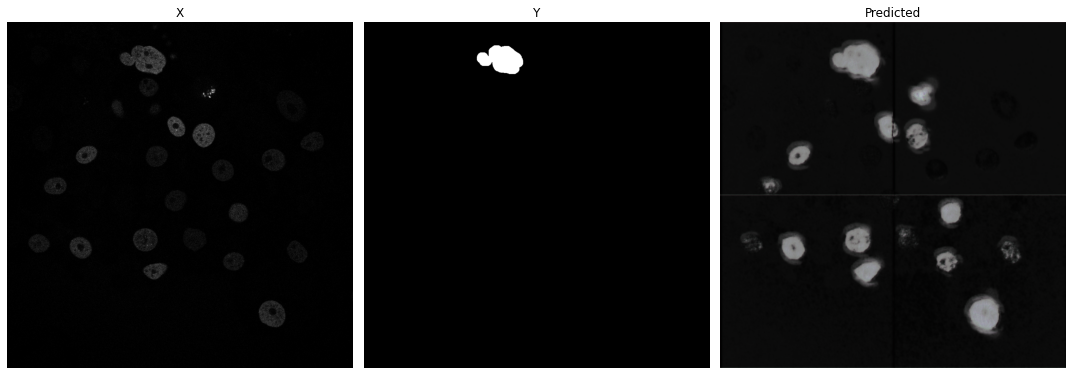

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
i = 92 # pleasant example
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


92


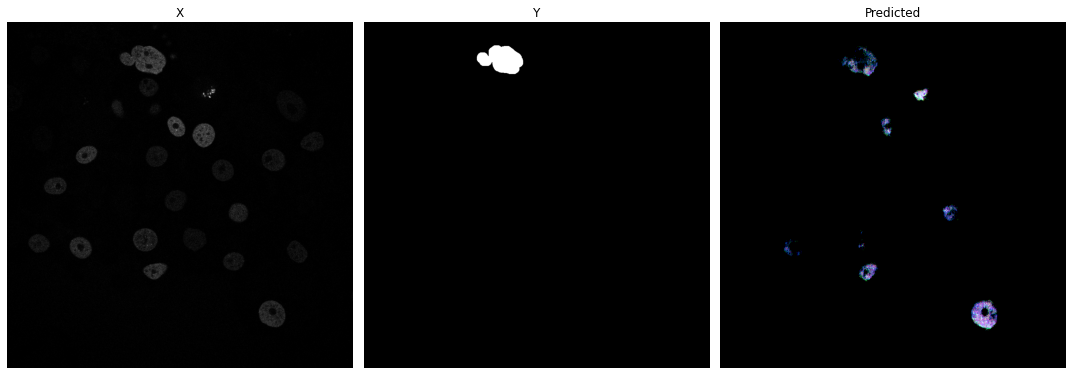

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.10329822616407983


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.06840977778077213


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


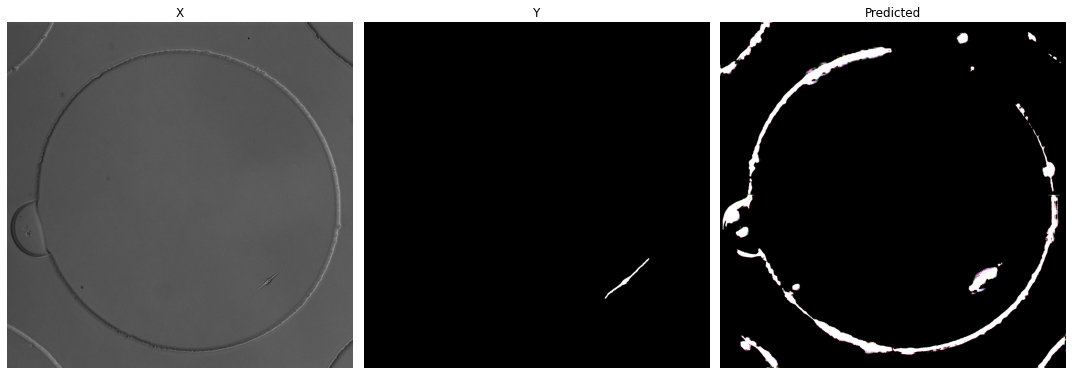

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.3885859376273618


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.15304007727614438


## GT Raw 512 2

### Load Model

In [39]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_512/"

model = getModel(path, "gt_512_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     0.9999727
Min Pixel:     4.226852e-07


190


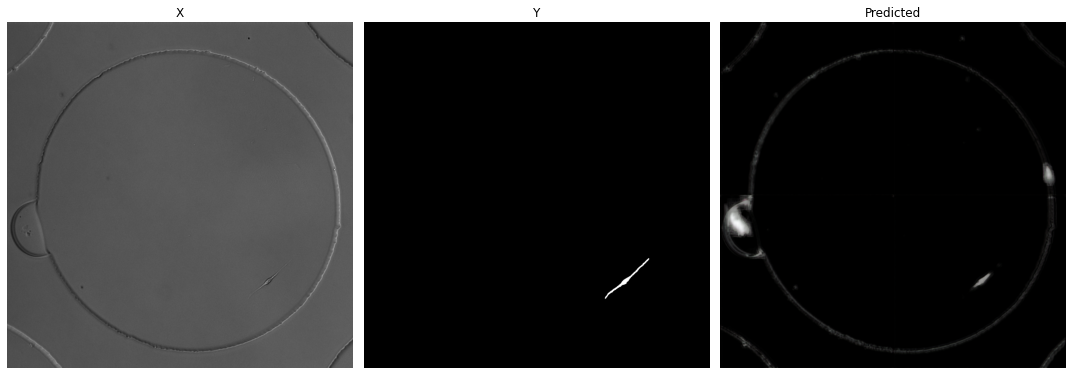

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [40]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


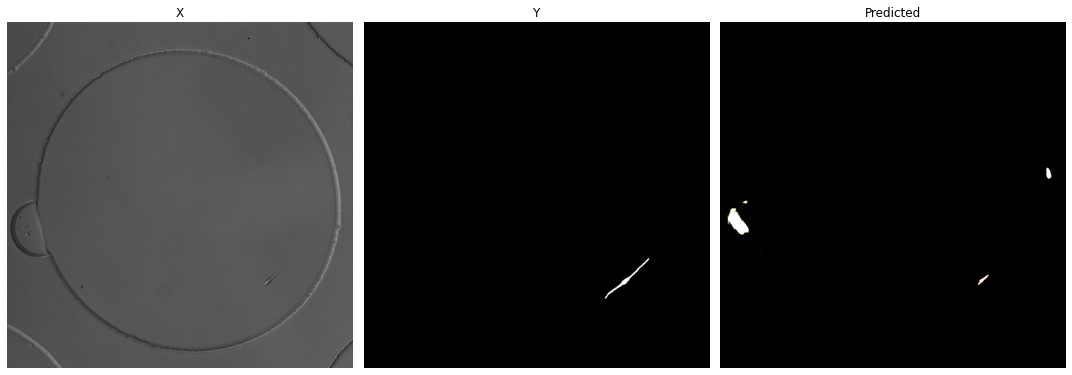

In [41]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [42]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.07961369606177893


In [43]:
import math
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    temp = calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])
    if (math.isnan(temp) == False):
        unet_128_model_score += temp

print(unet_128_model_score / len(test_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


0.13907567269182863


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


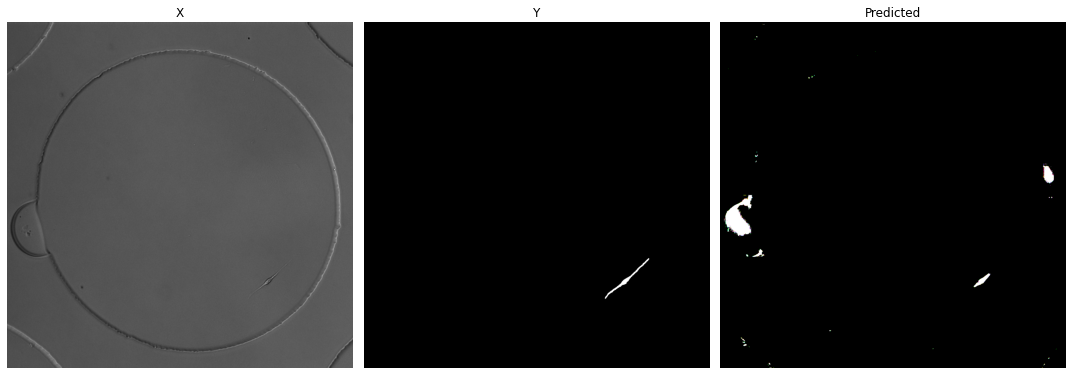

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.3842538679088338


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.19368772912309654


## GT Raw 512 3

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/GT_512/"

model = getModel(path, "gt_512_model_3")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     0.99899065
Min Pixel:     2.8535363e-19


190


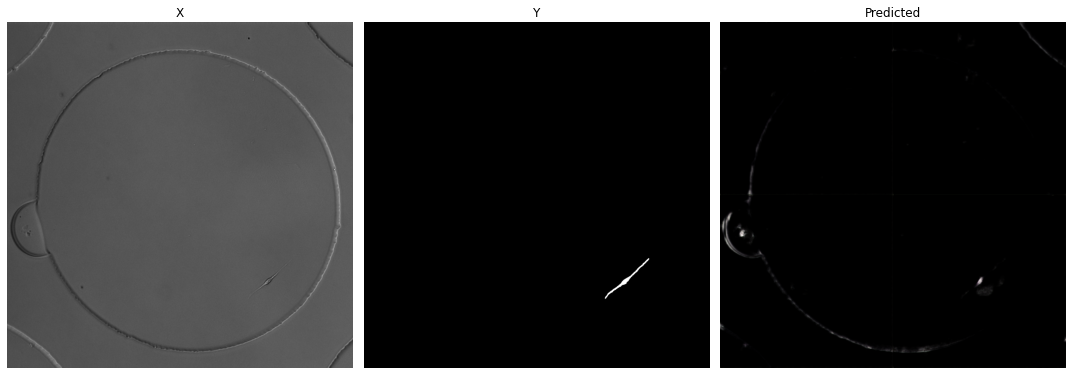

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


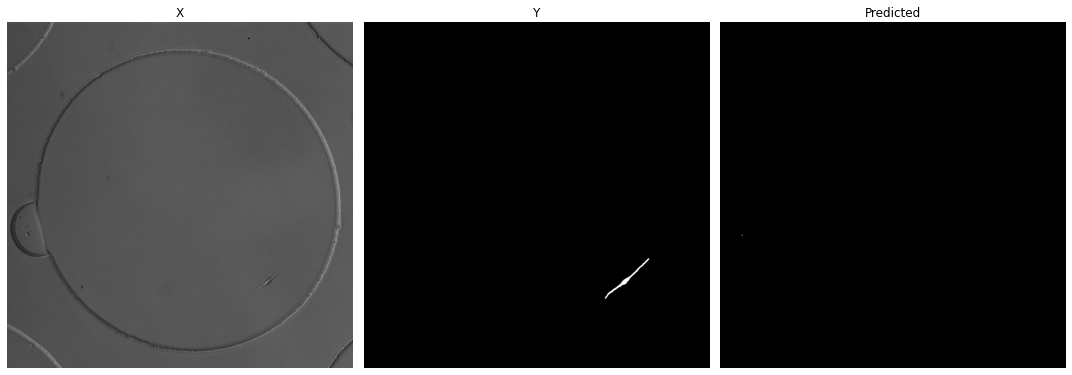

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.054826860105933975


In [ ]:
import math
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    temp = calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])
    if (math.isnan(temp) == False):
        unet_128_model_score += temp

print(unet_128_model_score / len(test_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


0.1831522061397772


### Threshold 0.25

In [ ]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 191
predicted 100 collections out of 191
predicted 150 collections out of 191


190


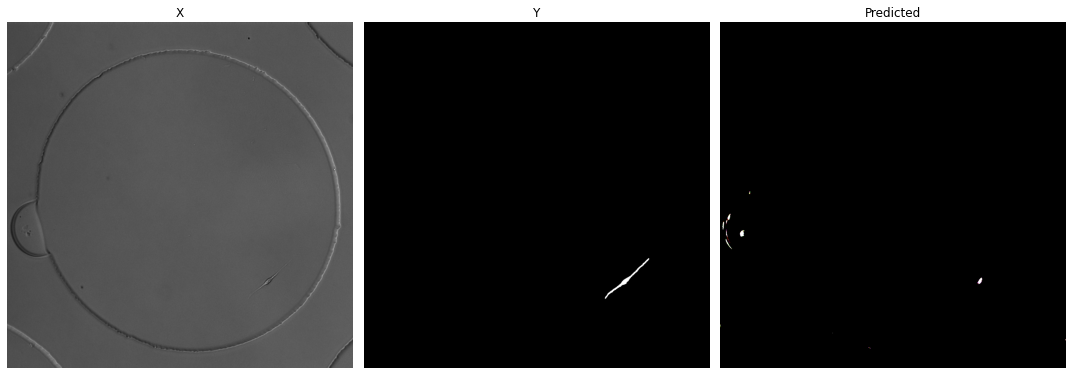

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_128_model_score)

0.39027685554079977


In [ ]:
import math
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    temp = calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])
    if (math.isnan(temp) == False):
        unet_128_model_score += temp

print(unet_128_model_score / len(test_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


0.2009801138453145


In [ ]:
import math
math.isnan(unet_128_model_score)

True

# ST Raw 128 Content

## ST 128 Prep

We next need to conduct a bulk Patchify process for each of the 4 models we desire to verify

In [ ]:
scaler = MinMaxScaler()
patch_size = 128

### Shuffle the data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    st_raw_x_images, st_raw_y_images, test_size=0.33, random_state=42
)

x_test = x_test[0:190]
y_test = y_test[0:190]

### Load Test X and Test Y Images

In [ ]:
# read in with opencv to produce 3 tuple images
test_x = []

for path in x_test:
    test_x.append(cropImage(cv2.imread(path), patch_size))

test_y = []

for path in y_test:
    img = plt.imread(path)
    plt.imsave("temp.png", img, cmap="gray")
    test_y.append(cropImage(cv2.imread("temp.png"), patch_size))

if (exists("temp.png")):
    remove("temp.png")

In [ ]:
binary_test_y = []

# update masks from multiclass to binary class
for i in range(len(test_y)):
    img = test_y[i].copy() # clone array to preserve info
    img[img > 0] = 1
    binary_test_y.append(img)

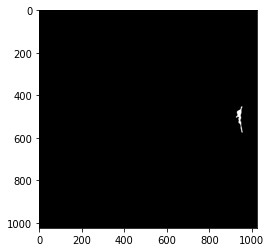

In [ ]:
plt.imshow(test_y[0])
plt.show()

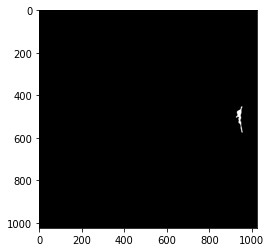

In [ ]:
plt.imshow(binary_test_y[0]*255) # update because 0 and 1
plt.show()

### Patchify all images

To avoid crashes, we need to limit the intake patches. Thankfully, we only need to use the test images, as the original training model did not see that!

In [ ]:
patch_size = 128
st_x_patchify_images, st_x_patchify_labels = patchifyImages(x_test, patch_size, imageIsMask=False)

print()
print(len(st_x_patchify_images), "images exist")

Patchifying 1/190 images
Patchifying 50/190 images
Patchifying 100/190 images
Patchifying 150/190 images
Patchify process complete!

9838 images exist


### Sort the patches into collections

Now, each image was cut into pieces, due to the patch size. We can take advantage of a property of the patchify process whereby 

(image_width // patch_size) * (image_height // patch_size) == number of patches

In [ ]:
patch_size = 128
st_x_organised_patches = []
starting_index, end_index = 0, 0

for path in x_test:
    image = plt.imread(path)
    X_PATCHES = (image.shape[1] // patch_size)
    Y_PATCHES = (image.shape[0] // patch_size)

    end_index = starting_index + (X_PATCHES * Y_PATCHES)

    st_x_organised_patches.append( st_x_patchify_images[starting_index : end_index] )

    starting_index = end_index # update


In [ ]:
len(st_x_organised_patches[0])

64

## ST Raw 128 1

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_128/"

model = getModel(path, "st_128_model_1")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 240
predicted 100 collections out of 240
predicted 150 collections out of 240
predicted 200 collections out of 240


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     3.4498246e-06


92


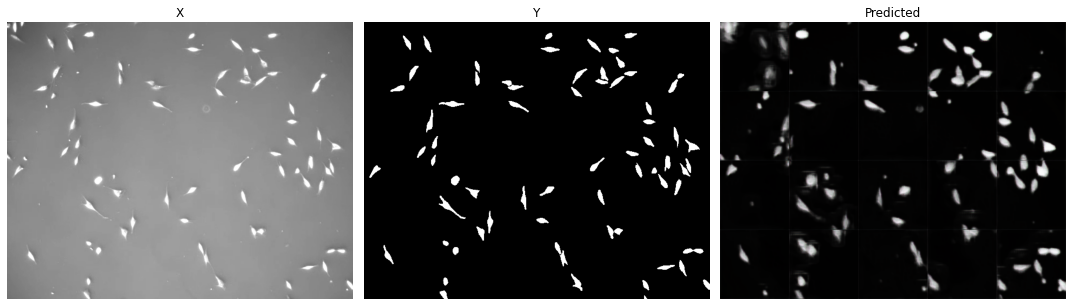

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
i = 92 # pleasant example
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 240
predicted 100 collections out of 240
predicted 150 collections out of 240
predicted 200 collections out of 240


239


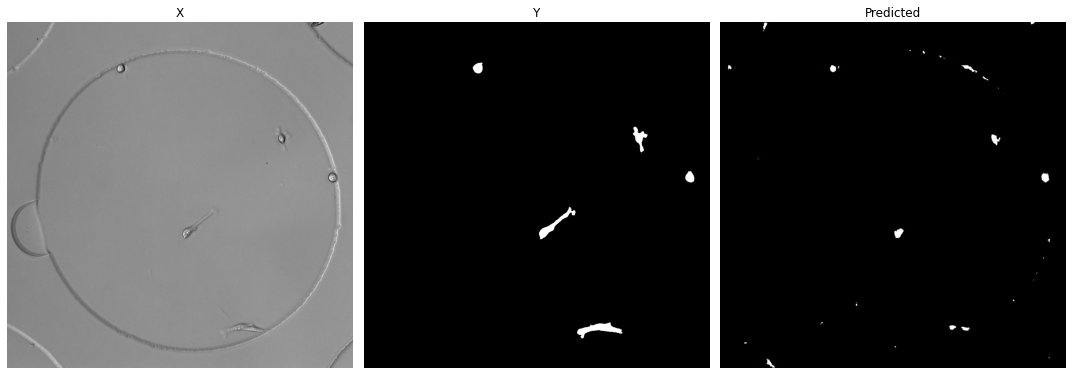

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.09410049349484073


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.3251814748327041


### Threshold 0.25

In [ ]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


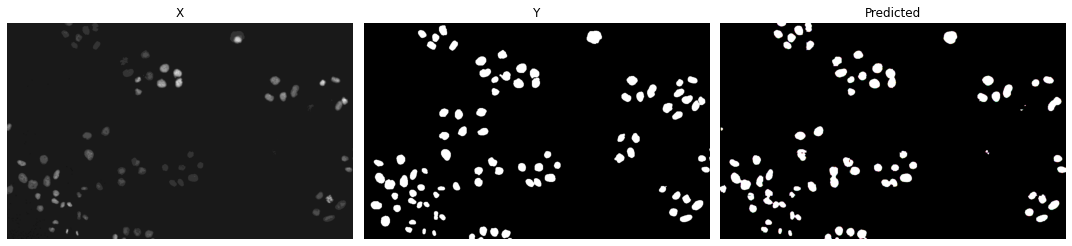

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.03438313994790433


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.23802847884935768


## ST Raw 128 2

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_128/"

model = getModel(path, "st_128_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     7.5711526e-30


189


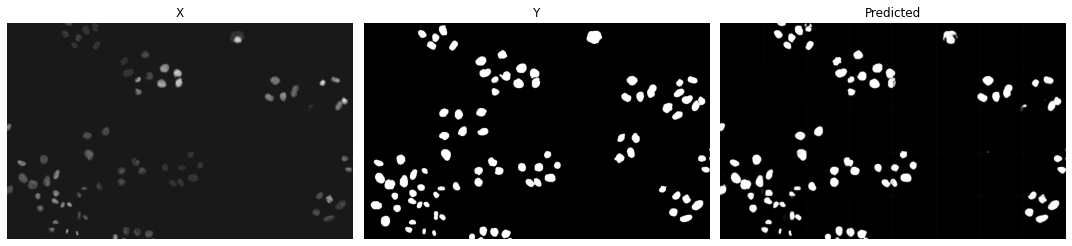

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


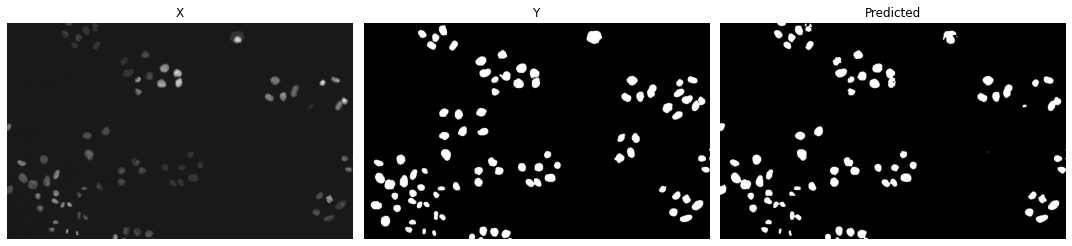

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.2940066068900425


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.5583357861507192


### Threshold 0.25

In [ ]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


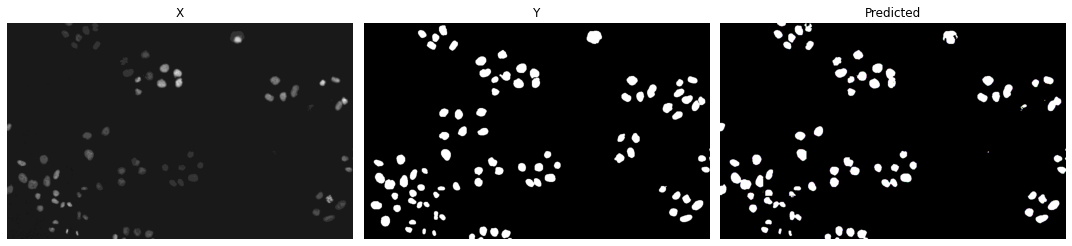

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.2934896378480218


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.5544092198300823


## ST Raw 128 3

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_128/"

model = getModel(path, "st_128_model_3")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     3.821714e-21


189


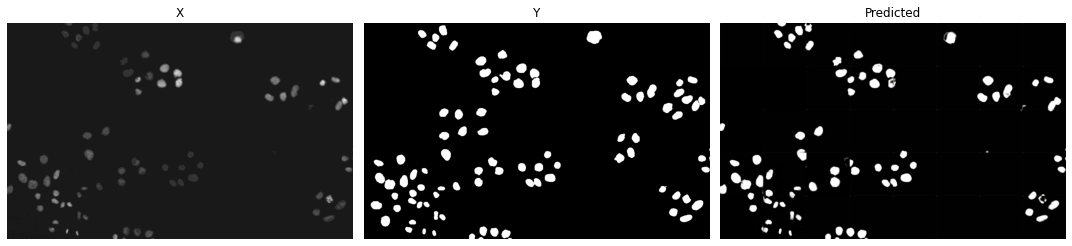

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


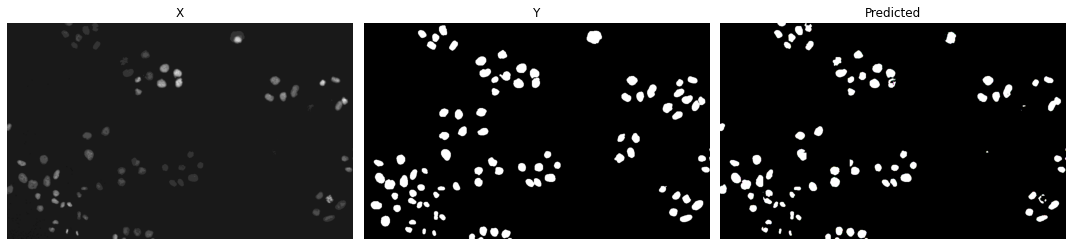

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.28032751562163327


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.571650680611828


### Threshold 0.25

In [ ]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


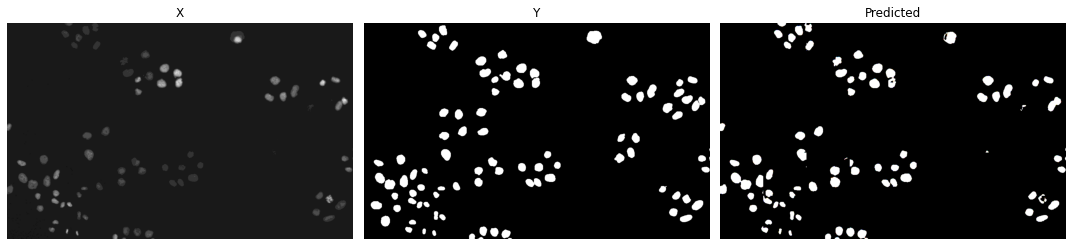

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.26844642195031515


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.5725539369042797


# ST Raw 256 Content

## ST 256 Prep

We next need to conduct a bulk Patchify process for each of the 4 models we desire to verify

In [30]:
scaler = MinMaxScaler()
patch_size = 256

### Shuffle the data

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    st_raw_x_images, st_raw_y_images, test_size=0.33, random_state=42
)

x_test = x_test[0:190]
y_test = y_test[0:190]

### Load Test X and Test Y Images

In [32]:
# read in with opencv to produce 3 tuple images
test_x = []

for path in x_test:
    test_x.append(cropImage(cv2.imread(path), patch_size))

test_y = []

for path in y_test:
    img = plt.imread(path)
    plt.imsave("temp.png", img, cmap="gray")
    test_y.append(cropImage(cv2.imread("temp.png"), patch_size))

if (exists("temp.png")):
    remove("temp.png")

In [33]:
binary_test_y = []

# update masks from multiclass to binary class
for i in range(len(test_y)):
    img = test_y[i].copy() # clone array to preserve info
    img[img > 0] = 1
    binary_test_y.append(img)

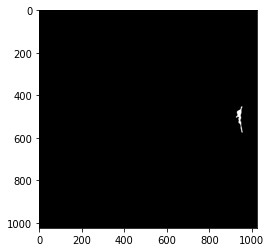

In [34]:
plt.imshow(test_y[0])
plt.show()

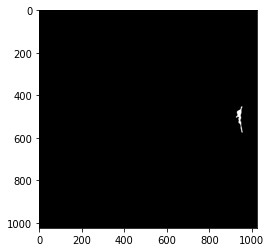

In [35]:
plt.imshow(binary_test_y[0]*255) # update because 0 and 1
plt.show()

### Patchify all images

To avoid crashes, we need to limit the intake patches. Thankfully, we only need to use the test images, as the original training model did not see that!

In [36]:
patch_size = 256
st_x_patchify_images, st_x_patchify_labels = patchifyImages(x_test, patch_size, imageIsMask=False)

print()
print(len(st_x_patchify_images), "images exist")

Patchifying 1/190 images
Patchifying 50/190 images
Patchifying 100/190 images
Patchifying 150/190 images
Patchify process complete!

2133 images exist


### Sort the patches into collections

Now, each image was cut into pieces, due to the patch size. We can take advantage of a property of the patchify process whereby 

(image_width // patch_size) * (image_height // patch_size) == number of patches

In [37]:
patch_size = 256
st_x_organised_patches = []
starting_index, end_index = 0, 0

for path in x_test:
    image = plt.imread(path)
    X_PATCHES = (image.shape[1] // patch_size)
    Y_PATCHES = (image.shape[0] // patch_size)

    end_index = starting_index + (X_PATCHES * Y_PATCHES)

    st_x_organised_patches.append( st_x_patchify_images[starting_index : end_index] )

    starting_index = end_index # update


In [38]:
len(st_x_organised_patches[0])

16

## ST Raw 256 1

### Load Model

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_256/"

model = getModel(path, "st_256_model_1")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [ ]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [ ]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     1.4516992e-10


92


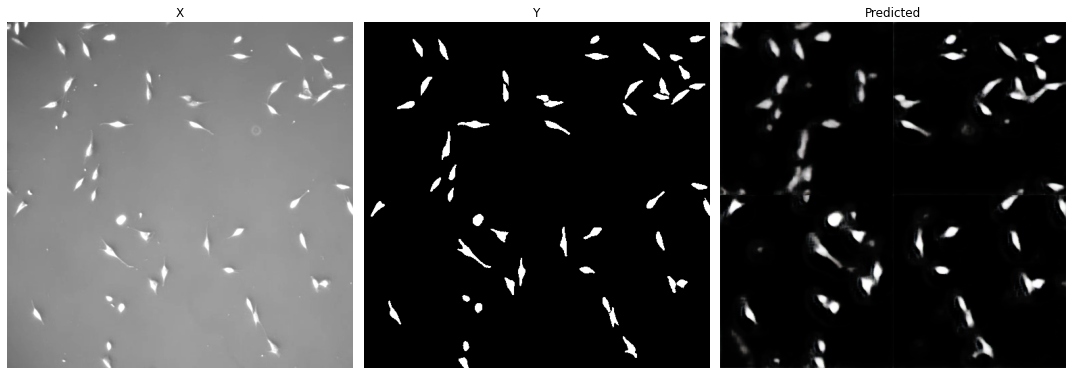

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
i = 92 # pleasant example
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [ ]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


92


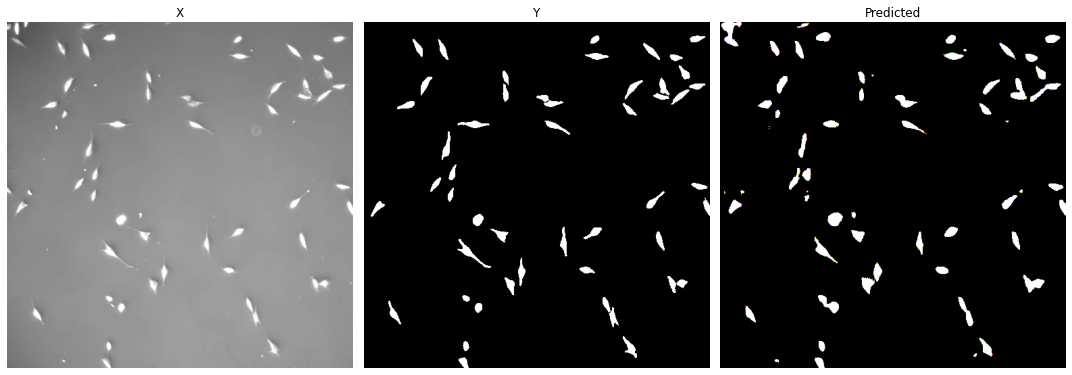

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.21876892028254288


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.4723232003575631


### Threshold 0.25

In [ ]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


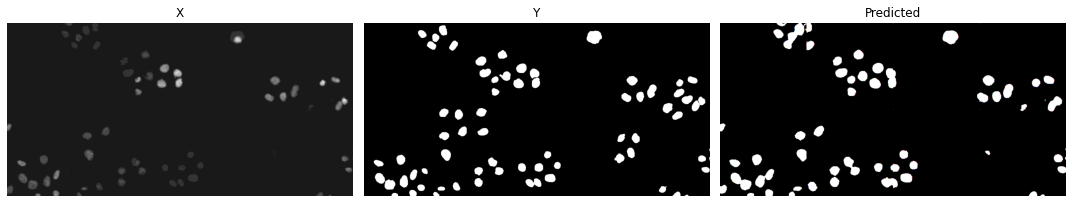

In [ ]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [ ]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.10189132144187393


In [ ]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.34891705029292186


## ST Raw 256 2

### Load Model

In [39]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_256/"

model = getModel(path, "st_256_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [40]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [41]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     0.0


189


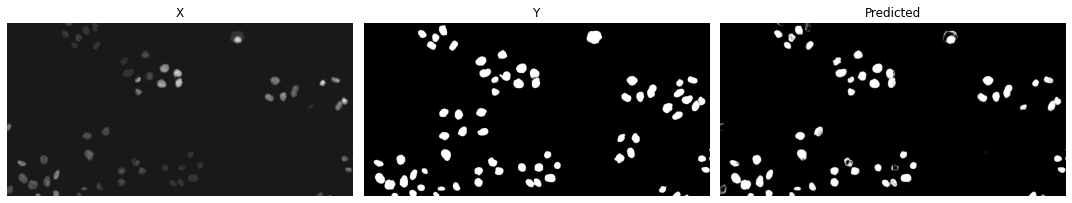

In [42]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [43]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


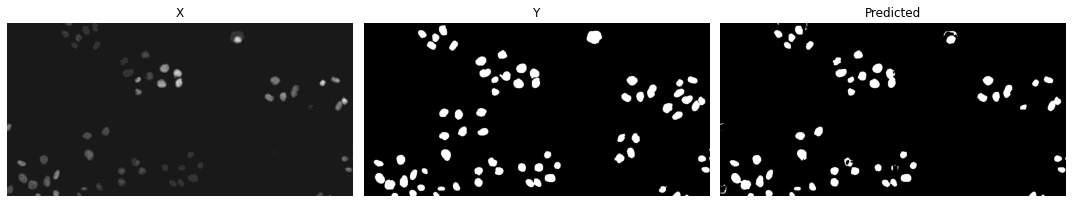

In [44]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [45]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.42186183656276327


In [46]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.7180737853169693


### Threshold 0.25

In [47]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


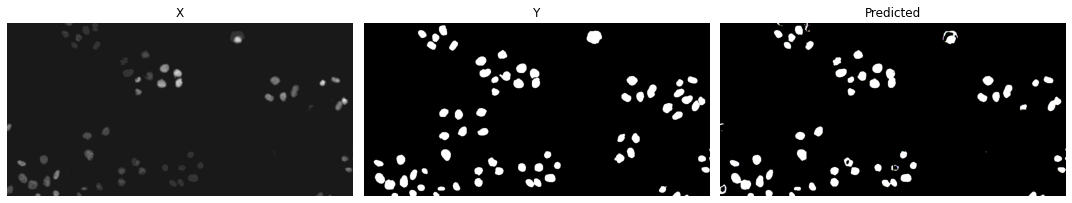

In [48]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [49]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.3908847184986595


In [50]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.668052308753074


## ST Raw 256 3

### Load Model

In [51]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_256/"

model = getModel(path, "st_256_model_3")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [52]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [53]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     0.0


189


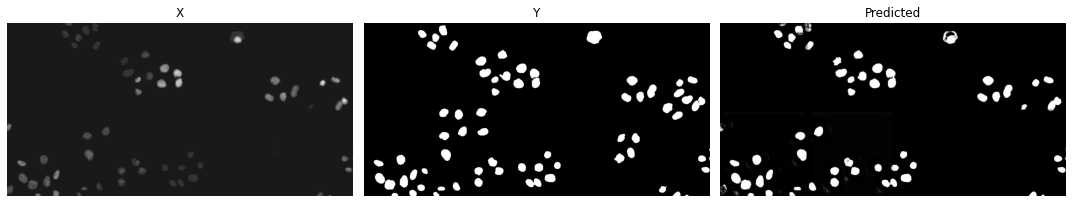

In [54]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [55]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


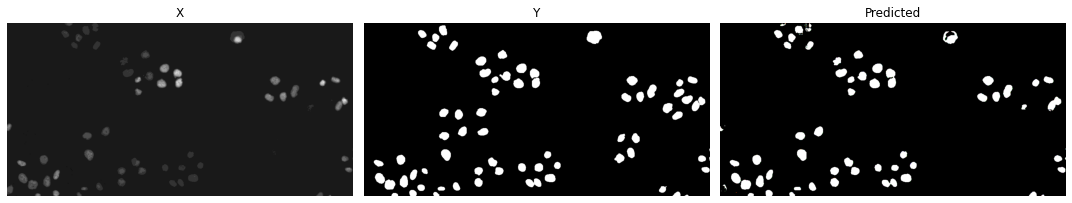

In [56]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [57]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.5148681055155875


In [58]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.7865471557741761


### Threshold 0.25

In [59]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


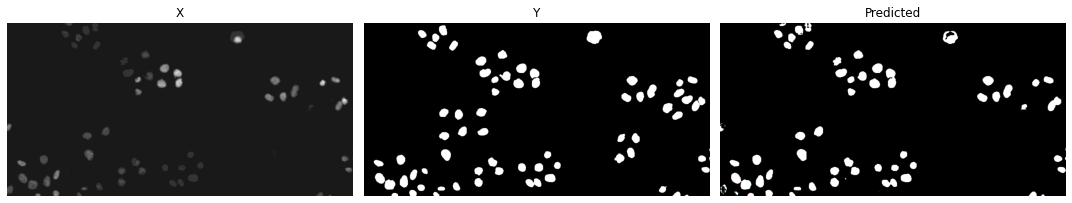

In [60]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [61]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.5179972311952007


In [62]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.7711902050585686


# ST Raw 512 Content

## ST 512 Prep

We next need to conduct a bulk Patchify process for each of the 4 models we desire to verify

In [44]:
scaler = MinMaxScaler()
patch_size = 512

### Shuffle the data

In [45]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    st_raw_x_images, st_raw_y_images, test_size=0.33, random_state=42
)

x_test = x_test[0:190]
y_test = y_test[0:190]

### Load Test X and Test Y Images

In [46]:
# read in with opencv to produce 3 tuple images
test_x = []

for path in x_test:
    test_x.append(cropImage(cv2.imread(path), patch_size))

test_y = []

for path in y_test:
    img = plt.imread(path)
    plt.imsave("temp.png", img, cmap="gray")
    test_y.append(cropImage(cv2.imread("temp.png"), patch_size))

if (exists("temp.png")):
    remove("temp.png")

In [47]:
binary_test_y = []

# update masks from multiclass to binary class
for i in range(len(test_y)):
    img = test_y[i].copy() # clone array to preserve info
    img[img > 0] = 1
    binary_test_y.append(img)

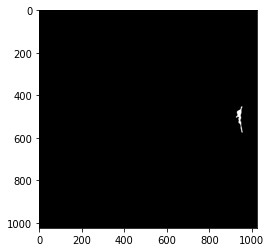

In [48]:
plt.imshow(test_y[0])
plt.show()

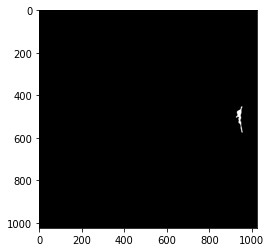

In [49]:
plt.imshow(binary_test_y[0]*255) # update because 0 and 1
plt.show()

### Patchify all images

To avoid crashes, we need to limit the intake patches. Thankfully, we only need to use the test images, as the original training model did not see that!

In [50]:
patch_size = 512
st_x_patchify_images, st_x_patchify_labels = patchifyImages(x_test, patch_size, imageIsMask=False)

print()
print(len(st_x_patchify_images), "images exist")

Patchifying 1/190 images
Patchifying 50/190 images
Patchifying 100/190 images
Patchifying 150/190 images
Patchify process complete!

417 images exist


### Sort the patches into collections

Now, each image was cut into pieces, due to the patch size. We can take advantage of a property of the patchify process whereby 

(image_width // patch_size) * (image_height // patch_size) == number of patches

In [51]:
patch_size = 512
st_x_organised_patches = []
starting_index, end_index = 0, 0

for path in x_test:
    image = plt.imread(path)
    X_PATCHES = (image.shape[1] // patch_size)
    Y_PATCHES = (image.shape[0] // patch_size)

    end_index = starting_index + (X_PATCHES * Y_PATCHES)

    st_x_organised_patches.append( st_x_patchify_images[starting_index : end_index] )

    starting_index = end_index # update


In [52]:
len(st_x_organised_patches[0])

4

## ST Raw 512 1

### Load Model

In [53]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_512/"

model = getModel(path, "st_512_model_1")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [73]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [74]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     0.5655602
Min Pixel:     1.9239343e-07


92


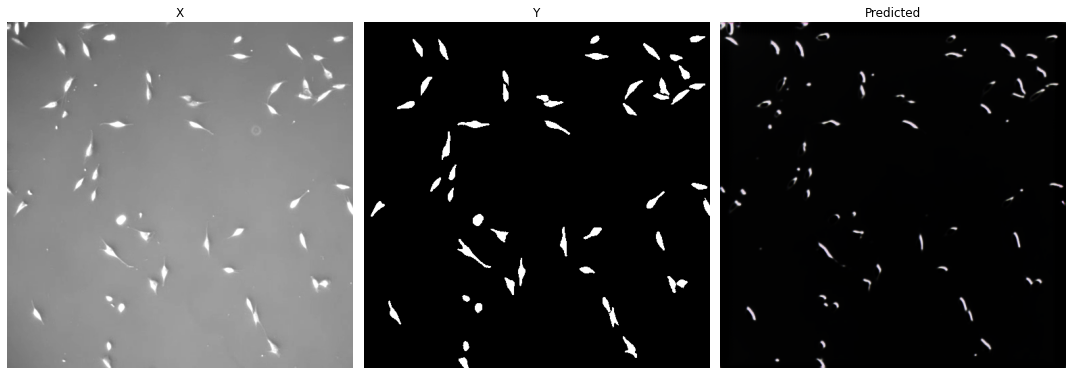

In [75]:
from random import randint

# i = randint(0, len(x_test)-1)
i = 92 # pleasant example
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [54]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


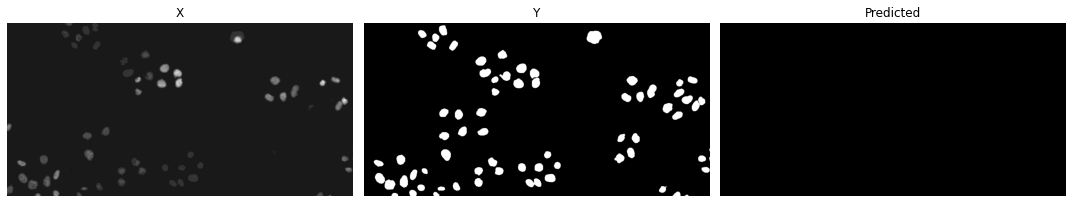

In [55]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [56]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.0


In [58]:
import math
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    temp = calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])
    if (math.isnan(temp) == False):
        unet_128_model_score += temp

print(unet_128_model_score / len(test_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


1.679911162478275e-05


### Threshold 0.25

In [80]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


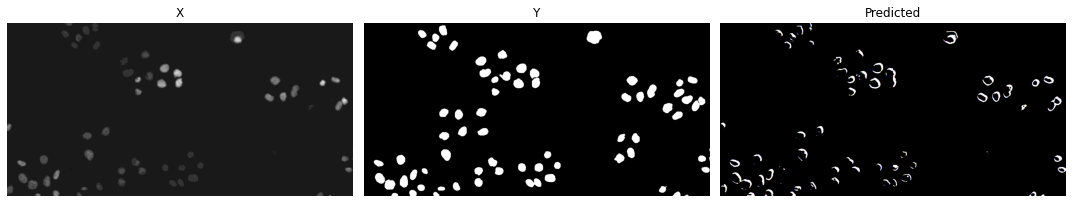

In [81]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [82]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.025777414075286414


In [83]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.16635794213723035


## ST Raw 512 2

### Load Model

In [59]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_512/"

model = getModel(path, "st_512_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [40]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [41]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     0.42151725
Min Pixel:     2.1811451e-07


189


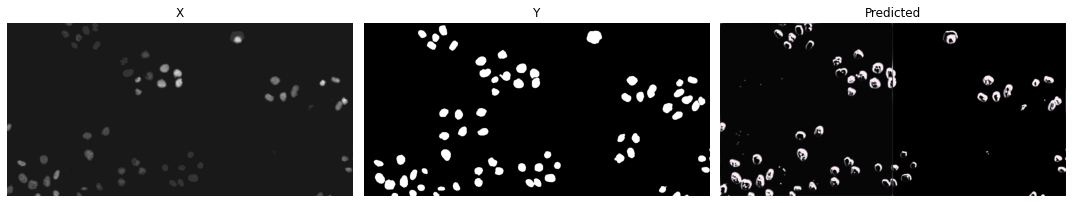

In [42]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [60]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


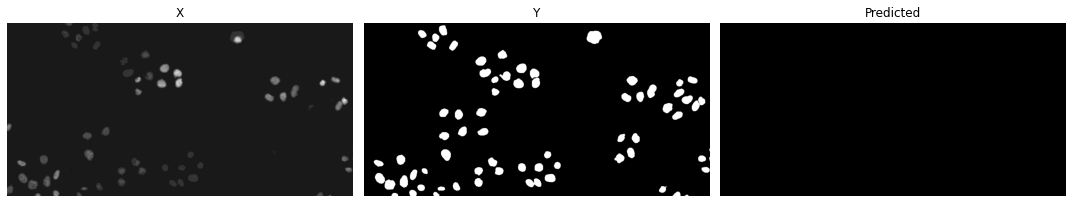

In [44]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [45]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.0


In [61]:
import math
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    temp = calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])
    if (math.isnan(temp) == False):
        unet_128_model_score += temp

print(unet_128_model_score / len(test_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


0.0


### Threshold 0.25

In [47]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


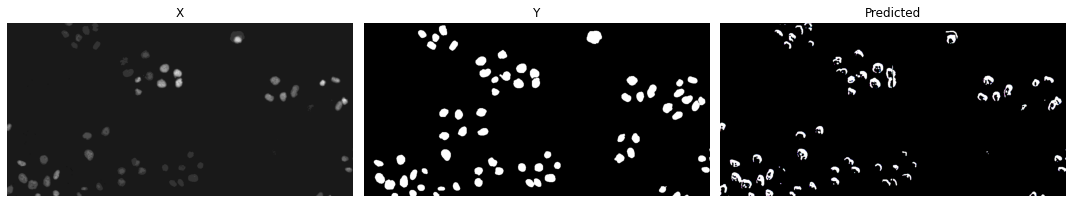

In [48]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [49]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.019779250446701195


In [50]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.1868067305717925


## ST Raw 512 3

### Load Model

In [51]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/ST_512/"

model = getModel(path, "st_512_model_3")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [52]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [53]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     2.0032917e-34


189


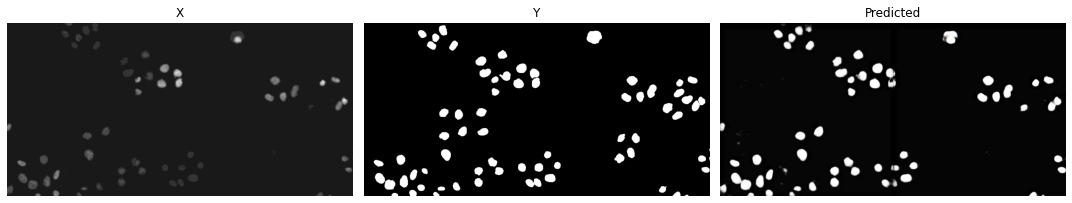

In [54]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [55]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


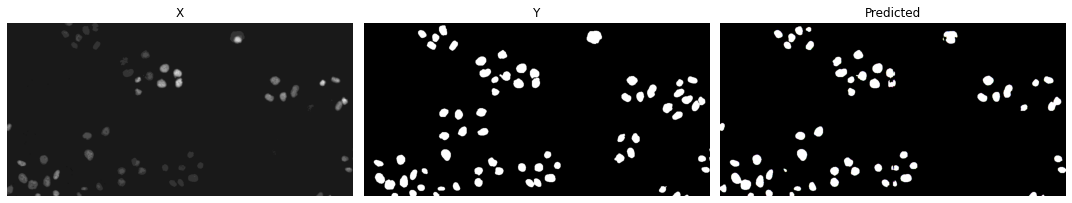

In [56]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [57]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.3678516228748068


In [58]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


nan


### Threshold 0.25

In [59]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


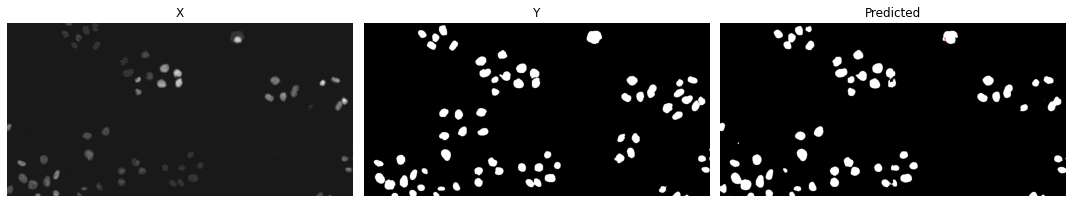

In [60]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [61]:
unet_128_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_128_model_score)

0.3976387249114522


In [62]:
#overall score
unet_128_model_score = 0

for i in range(len(test_x)):
    unet_128_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_128_model_score / len(test_x))

0.501579367402848


# GT Processed 256 Content

## GT 256 Prep

We next need to conduct a bulk Patchify process for each of the 4 models we desire to verify

In [30]:
scaler = MinMaxScaler()
patch_size = 256

### Shuffle the data

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    gt_processed_x_images, gt_processed_y_images, test_size=0.33, random_state=42
)

x_test = x_test[0:190]
y_test = y_test[0:190]

### Load Test X and Test Y Images

In [32]:
# read in with opencv to produce 3 tuple images
test_x = []

for path in x_test:
    test_x.append(cropImage(cv2.imread(path), patch_size))

test_y = []

for path in y_test:
    img = plt.imread(path)
    plt.imsave("temp.png", img, cmap="gray")
    test_y.append(cropImage(cv2.imread("temp.png"), patch_size))

if (exists("temp.png")):
    remove("temp.png")

In [33]:
binary_test_y = []

# update masks from multiclass to binary class
for i in range(len(test_y)):
    img = test_y[i].copy() # clone array to preserve info
    img[img > 0] = 1
    binary_test_y.append(img)

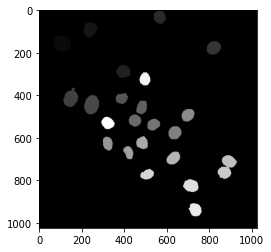

In [34]:
plt.imshow(test_y[0])
plt.show()

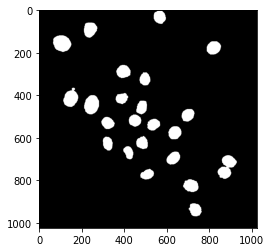

In [35]:
plt.imshow(binary_test_y[0]*255) # update because 0 and 1
plt.show()

### Patchify all images

To avoid crashes, we need to limit the intake patches. Thankfully, we only need to use the test images, as the original training model did not see that!

In [36]:
patch_size = 256
gt_x_patchify_images, gt_x_patchify_labels = patchifyImages(x_test, patch_size, imageIsMask=False)

print()
print(len(gt_x_patchify_images), "images exist")

Patchifying 1/190 images
Patchifying 50/190 images
Patchifying 100/190 images
Patchifying 150/190 images
Patchify process complete!

1869 images exist


### Sort the patches into collections

Now, each image was cut into pieces, due to the patch size. We can take advantage of a property of the patchify process whereby 

(image_width // patch_size) * (image_height // patch_size) == number of patches

In [37]:
patch_size = 256
gt_x_organised_patches = []
starting_index, end_index = 0, 0

for path in x_test:
    image = plt.imread(path)
    X_PATCHES = (image.shape[1] // patch_size)
    Y_PATCHES = (image.shape[0] // patch_size)

    end_index = starting_index + (X_PATCHES * Y_PATCHES)

    gt_x_organised_patches.append( gt_x_patchify_images[starting_index : end_index] )

    starting_index = end_index # update


In [38]:
len(gt_x_organised_patches[0])

16

## GT Processed 256 1

### Load Model

In [39]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"

model = getModel(path, "processed_gt_images_256_model_1")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [74]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [75]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     0.9999999
Min Pixel:     6.164263e-13


92


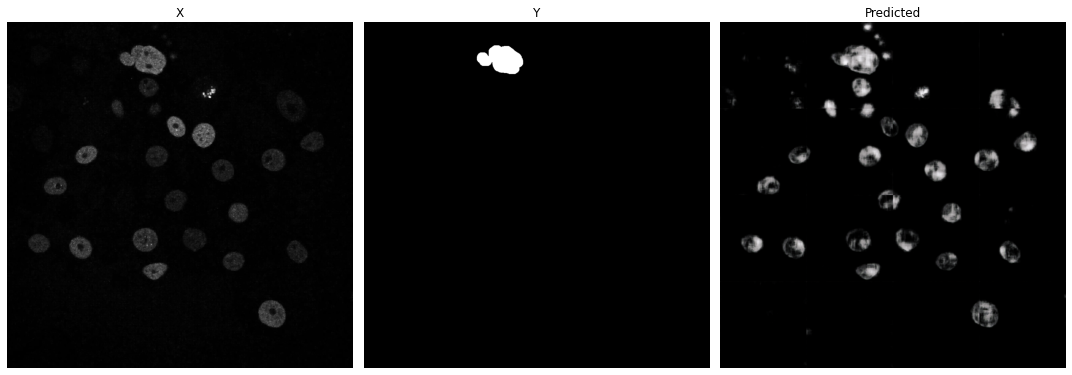

In [76]:
from random import randint

# i = randint(0, len(x_test)-1)
i = 92 # pleasant example
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [40]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


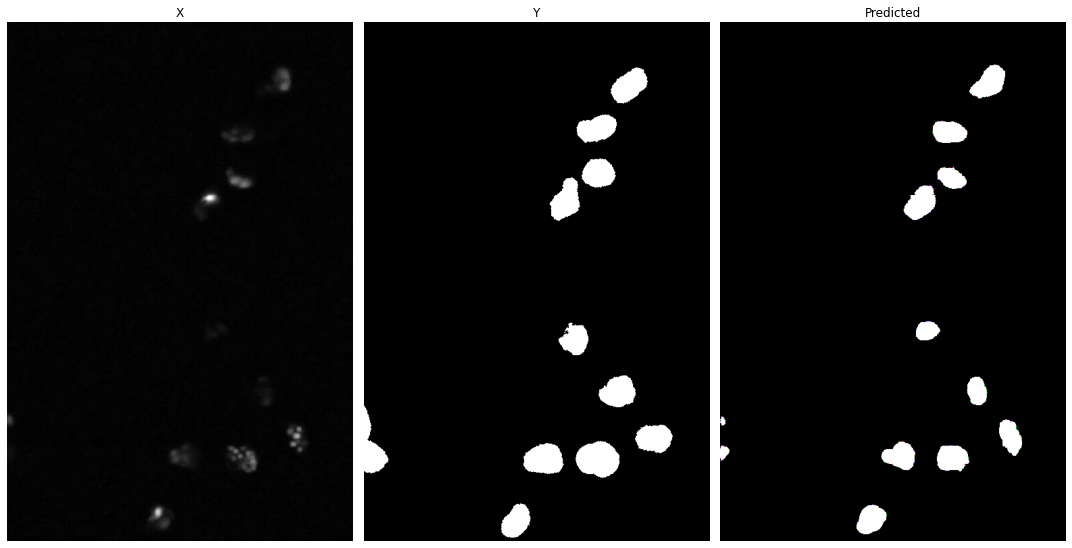

In [41]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [42]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_model_score)

0.3153535325800945


In [43]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.4163448092023862


### Threshold 0.25

In [44]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


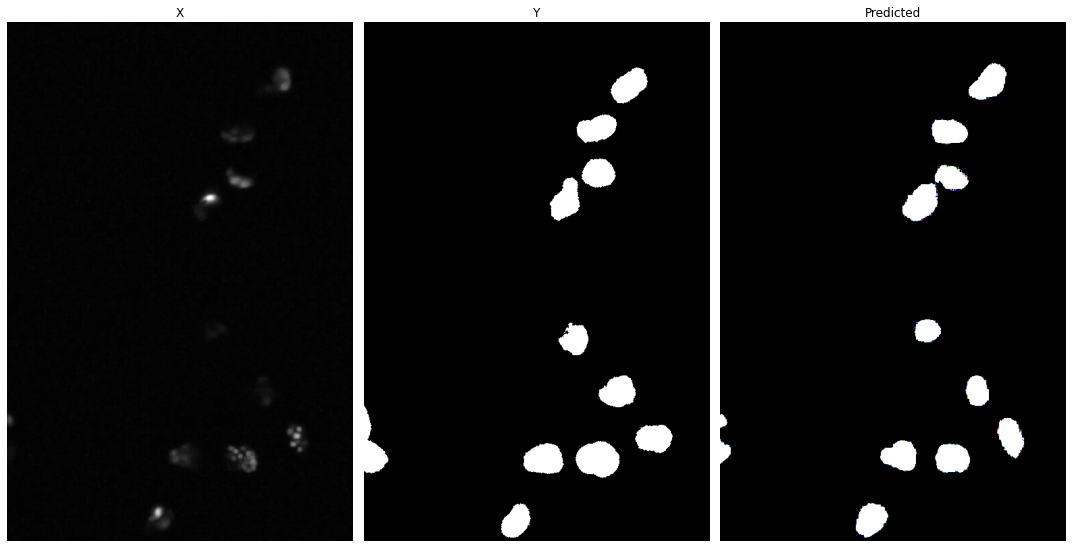

In [45]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [46]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_model_score)

0.520908822088543


In [47]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.41933956176943804


## GT Processed 256 2

### Load Model

In [48]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"

model = getModel(path, "processed_gt_images_256_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [49]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [50]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     7.292954e-21


189


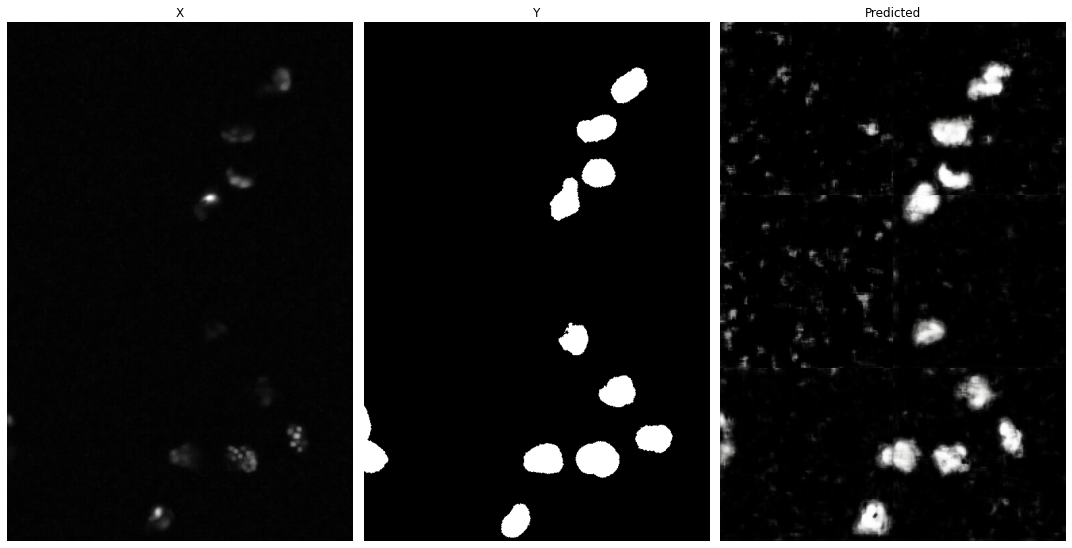

In [51]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [52]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


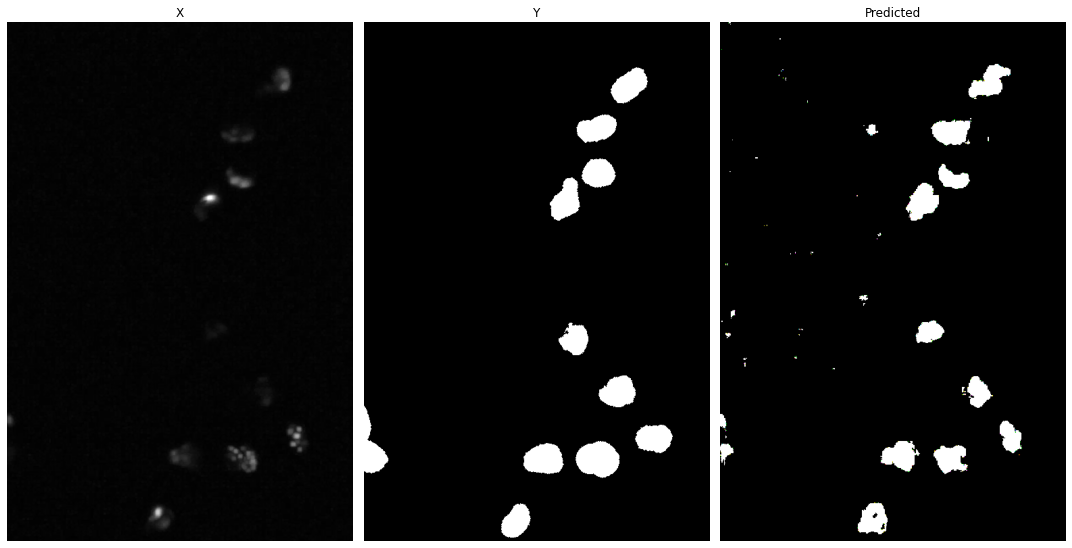

In [53]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [54]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_model_score)

0.35125134922522455


In [55]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.3384665048796868


### Threshold 0.25

In [56]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


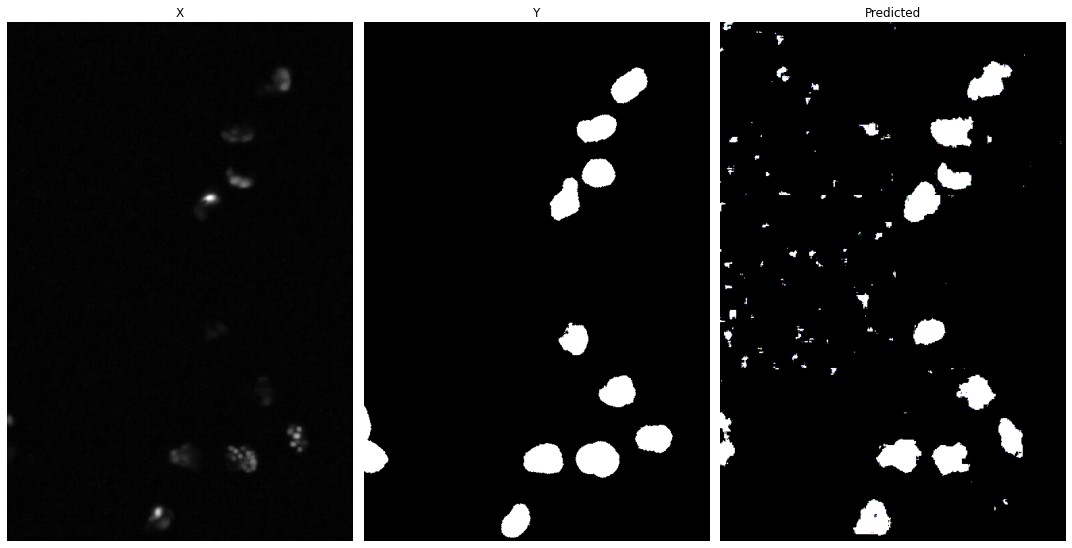

In [57]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [58]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_model_score)

0.5765998959417273


In [59]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.3372460497131287


## GT Processed 256 3

### Load Model

In [60]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"

model = getModel(path, "processed_gt_images_256_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [61]:
threshold = 0

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [62]:
from scipy import stats as st
min, max = -1, -1

for image in gt_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     7.292954e-21


189


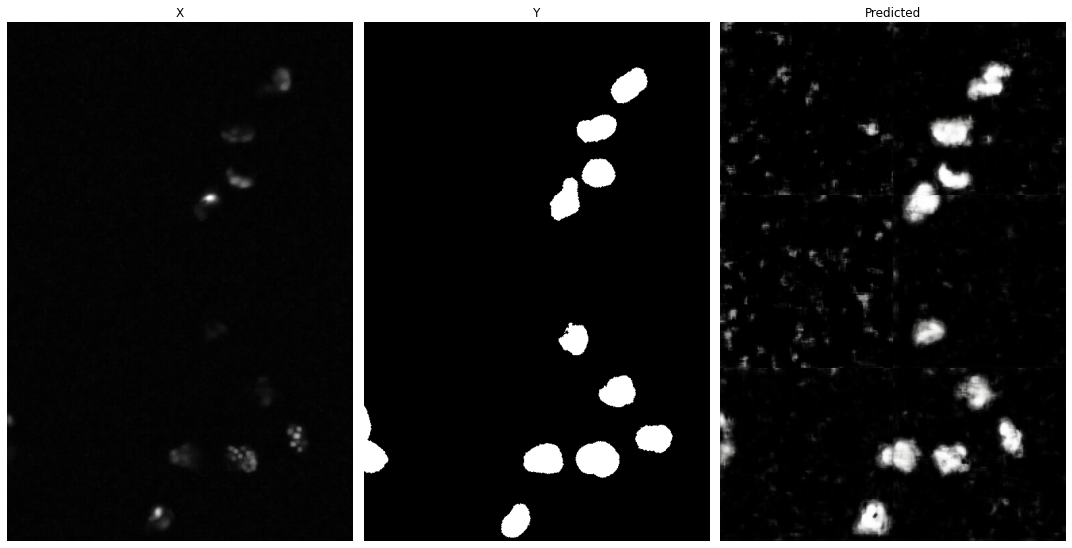

In [63]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [64]:
threshold = 0.5

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


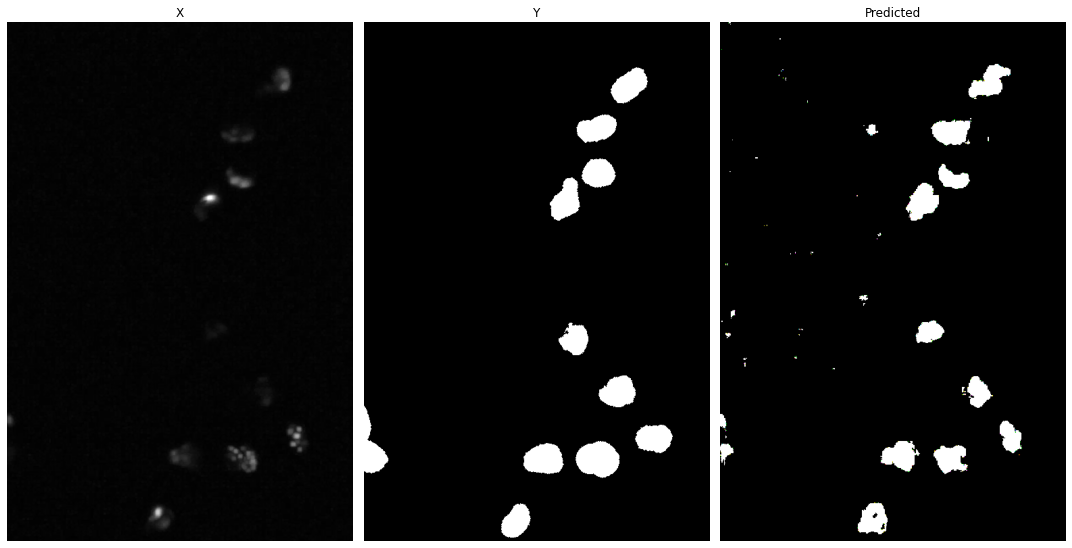

In [65]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [66]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_model_score)

0.35125134922522455


In [67]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.3384665048796868


### Threshold 0.25

In [68]:
threshold = 0.25

gt_rebuilt_predictions = predictPatchesAndRebuild(x_test, gt_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


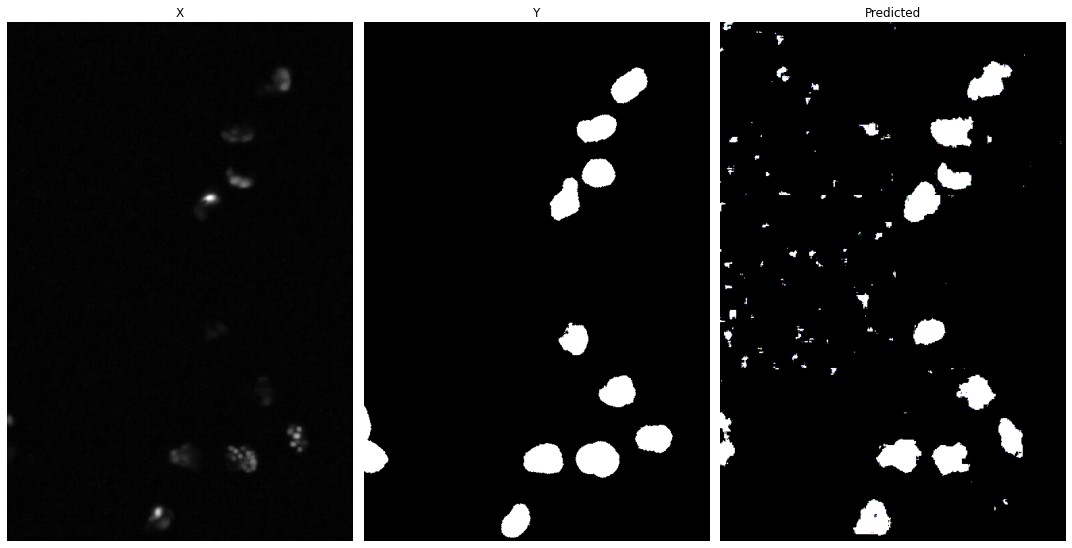

In [69]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, gt_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [70]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], gt_rebuilt_predictions[0])
print(unet_model_score)

0.5765998959417273


In [71]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], gt_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.3372460497131287


# ST Processed 256 Content

## ST 256 Prep

We next need to conduct a bulk Patchify process for each of the 4 models we desire to verify

In [30]:
scaler = MinMaxScaler()
patch_size = 256

### Shuffle the data

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    st_processed_x_images, st_processed_y_images, test_size=0.33, random_state=42
)

x_test = x_test[0:190]
y_test = y_test[0:190]

### Load Test X and Test Y Images

In [32]:
# read in with opencv to produce 3 tuple images
test_x = []

for path in x_test:
    test_x.append(cropImage(cv2.imread(path), patch_size))

test_y = []

for path in y_test:
    img = plt.imread(path)
    plt.imsave("temp.png", img, cmap="gray")
    test_y.append(cropImage(cv2.imread("temp.png"), patch_size))

if (exists("temp.png")):
    remove("temp.png")

In [33]:
binary_test_y = []

# update masks from multiclass to binary class
for i in range(len(test_y)):
    img = test_y[i].copy() # clone array to preserve info
    img[img > 0] = 1
    binary_test_y.append(img)

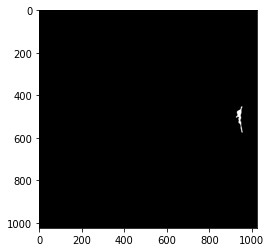

In [34]:
plt.imshow(test_y[0])
plt.show()

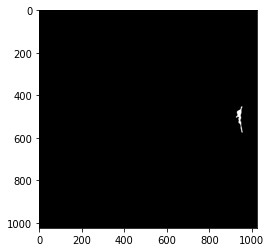

In [35]:
plt.imshow(binary_test_y[0]*255) # update because 0 and 1
plt.show()

### Patchify all images

To avoid crashes, we need to limit the intake patches. Thankfully, we only need to use the test images, as the original training model did not see that!

In [36]:
patch_size = 256
st_x_patchify_images, st_x_patchify_labels = patchifyImages(x_test, patch_size, imageIsMask=False)

print()
print(len(st_x_patchify_images), "images exist")

Patchifying 1/190 images
Patchifying 50/190 images
Patchifying 100/190 images
Patchifying 150/190 images
Patchify process complete!

2133 images exist


### Sort the patches into collections

Now, each image was cut into pieces, due to the patch size. We can take advantage of a property of the patchify process whereby 

(image_width // patch_size) * (image_height // patch_size) == number of patches

In [37]:
patch_size = 256
st_x_organised_patches = []
starting_index, end_index = 0, 0

for path in x_test:
    image = plt.imread(path)
    X_PATCHES = (image.shape[1] // patch_size)
    Y_PATCHES = (image.shape[0] // patch_size)

    end_index = starting_index + (X_PATCHES * Y_PATCHES)

    st_x_organised_patches.append( st_x_patchify_images[starting_index : end_index] )

    starting_index = end_index # update


In [38]:
len(st_x_organised_patches[0])

16

## ST Processed 256 1

### Load Model

In [39]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"

model = getModel(path, "processed_st_images_256_model_1")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [82]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [83]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     4.752089e-11


92


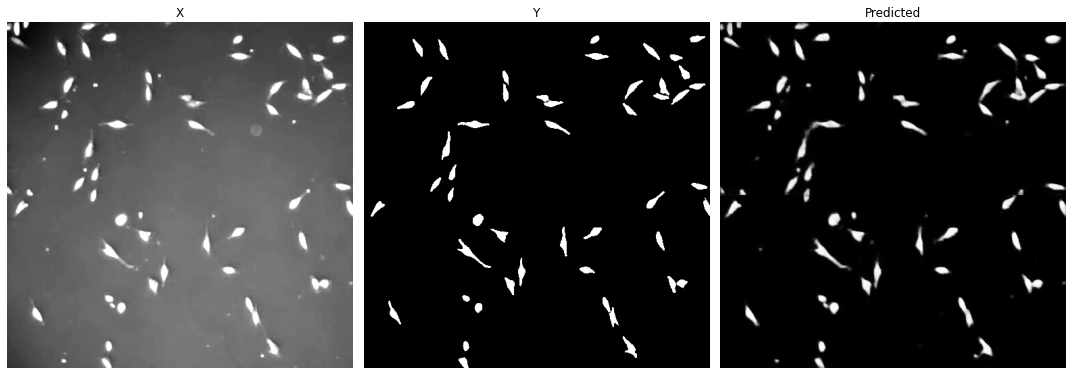

In [84]:
from random import randint

# i = randint(0, len(x_test)-1)
i = 92 # pleasant example
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [40]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


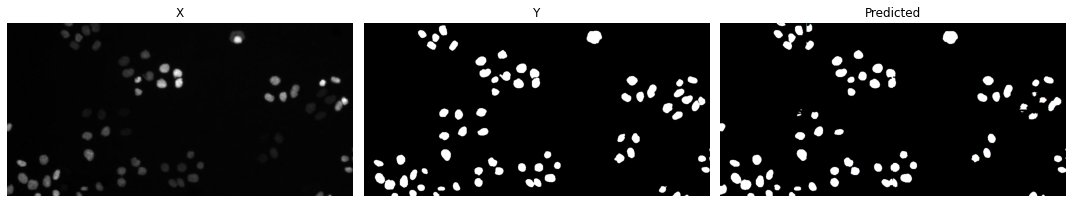

In [41]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [42]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_model_score)

0.24769085768143262


In [43]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.5461525314296748


### Threshold 0.25

In [44]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


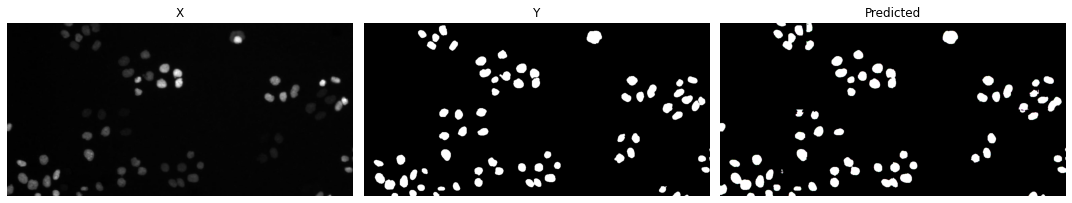

In [45]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [46]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_model_score)

0.17213628762541805


In [47]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.5063278248719899


## ST Processed 256 2

### Load Model

In [48]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"

model = getModel(path, "processed_st_images_256_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [49]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [50]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     0.0


189


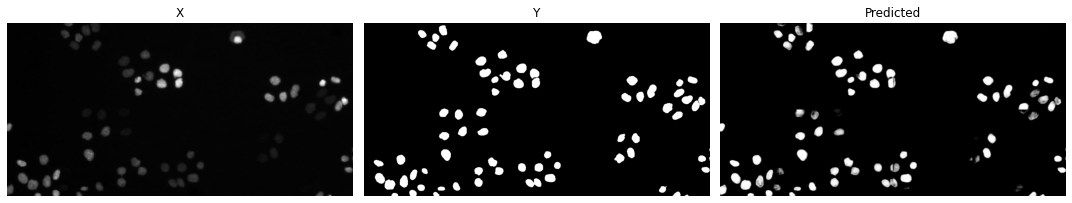

In [51]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [52]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


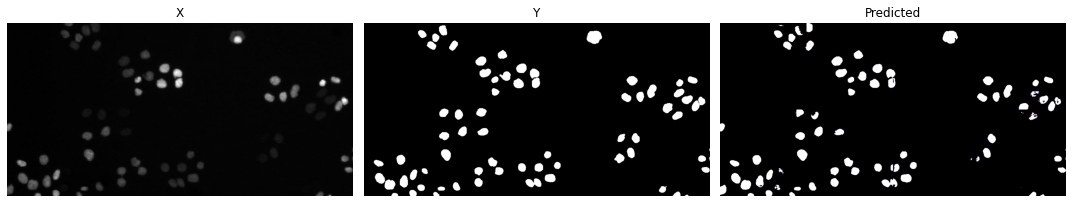

In [53]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [54]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_model_score)

0.4634691848906561


In [55]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.667407267721469


### Threshold 0.25

In [56]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


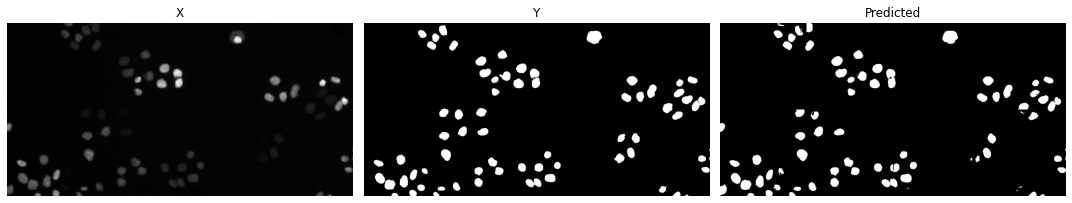

In [57]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [58]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_model_score)

0.4172498970769864


In [59]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.6657365148356245


## ST Processed 256 3

### Load Model

In [60]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"

model = getModel(path, "processed_st_images_256_model_2")

# new_model.summary()

Now that we have that working, let us conduct the bulk predict and stitch:

### No Threshold

In [61]:
threshold = 0

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=False)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


In [62]:
from scipy import stats as st
min, max = -1, -1

for image in st_rebuilt_predictions:
    if (min == -1):
        min = np.min(image)
        max = np.max(image)
        continue
    
    if (np.max(image) > max):
        max = np.max(image)
    
    if (np.min(image) < min):
        min = np.min(image)

print("Max Pixel:    ", max)
print("Min Pixel:    ", min)

Max Pixel:     1.0
Min Pixel:     0.0


189


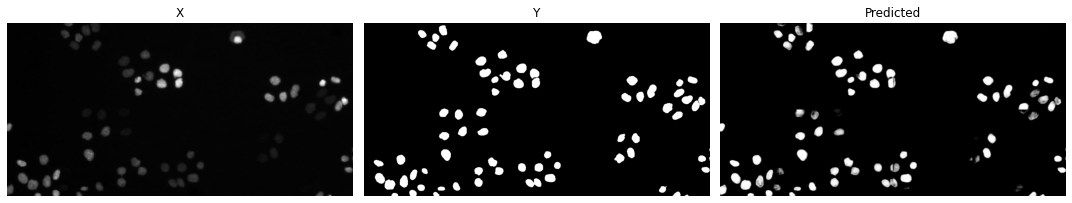

In [63]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

### Threshold 0.5

In [64]:
threshold = 0.5

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


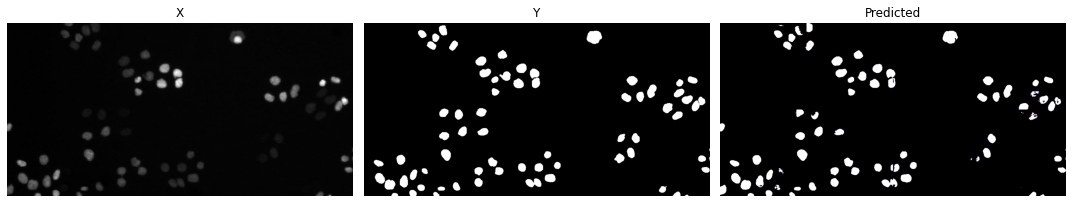

In [65]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

This score should basically be zero, after reviewing the previous results. Let's check:

In [66]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_model_score)

0.4634691848906561


In [67]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.667407267721469


### Threshold 0.25

In [68]:
threshold = 0.25

st_rebuilt_predictions = predictPatchesAndRebuild(x_test, st_x_organised_patches, patch_size, model, threshold, invert_scaling=False, apply_threshold=True)

predicted 50 collections out of 190
predicted 100 collections out of 190
predicted 150 collections out of 190


189


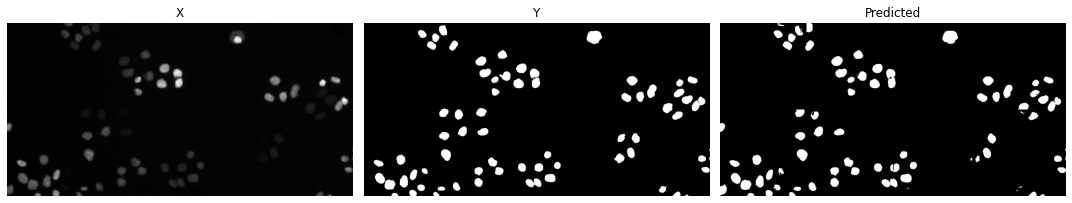

In [69]:
from random import randint

# i = randint(0, len(x_test)-1)
print(i)

# mulitply test_y by 255 because pixels are in domain {0, 1} as dtype=int
array = [test_x[i], binary_test_y[i]*255, st_rebuilt_predictions[i]]
labels = ["X", "Y", "Predicted"]

display(array, labels)

In [70]:
unet_model_score = calculateMeanIouScore(model, test_x[0], binary_test_y[0], st_rebuilt_predictions[0])
print(unet_model_score)

0.4172498970769864


In [71]:
#overall score
unet_model_score = 0

for i in range(len(test_x)):
    unet_model_score += calculateMeanIouScore(model, test_x[i], binary_test_y[i], st_rebuilt_predictions[i])

print(unet_model_score / len(test_x))

0.6657365148356245
